In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import h5py

import torch
from torch.nn import functional as F
from torch.autograd import Variable

##############################
from models import deeplab_xception
from models import tiramisu
from models import unet
from datasets import datasets
from utils import manager as mgr
from utils import img_utils
##############################

# set device
#device = torch.device(DEVICE if torch.cuda.is_available() else "cpu")
#exp_name = 'unet_df_030_001'
#WEIGHTS_PATH = '/home/philipp/Data/weights/'+exp_name+'/'
WEIGHTS_PATH = '/home/philipp/Code/python/edin_prediction/weights/'
device = "cuda:0"
#device = "cpu"
print(device)

architecture = 'deeplab_adj_age3'#'deeplab'#'densenet'
nr_channels = 8
nr_classes = 4

cuda:0


In [2]:
## load model with weights

In [4]:
if architecture == 'unet':
    model = unet.UNET(in_channels=nr_channels, out_channels=nr_classes)
    weights_name = 'unet_dice_weights-19-0.217-0.821.pth'
    path = WEIGHTS_PATH + weights_name
    
elif architecture == 'densenet':
    model = tiramisu.FCDenseNet57(in_channels=nr_channels, n_classes=nr_classes)
    weights_name = 'densenet_dice_weights-3-0.186-0.808.pth'
    path = WEIGHTS_PATH + weights_name
    
elif architecture == 'deeplab':
    model = deeplab_xception.DeepLabv3_plus(nInputChannels=nr_channels, n_classes=nr_classes, os=16, pretrained=False)
    weights_name = 'deeplab_dice_weights-21-0.192-0.818.pth'
    path = WEIGHTS_PATH + weights_name
    
elif architecture == 'deeplab_ce':
    model = deeplab_xception.DeepLabv3_plus(nInputChannels=nr_channels, n_classes=nr_classes, os=16, pretrained=False)
    weights_name = 'deeplab_ce_weights-4-0.453-0.814.pth'
    path = WEIGHTS_PATH + weights_name
    
elif architecture == 'deeplab_adj':
    model = deeplab_xception.DeepLabv3_plus(nInputChannels=nr_channels, n_classes=nr_classes, os=16, pretrained=False)
    weights_name = 'weights-22-0.175-0.836.pth'
    path = '/home/philipp/Code/work/edin_deeplab_adj/weights/' + weights_name
    
elif architecture == 'deeplab_adj_age':
    model = deeplab_xception.DeepLabv3_plus(nInputChannels=nr_channels, n_classes=nr_classes, os=16, pretrained=False)
    weights_name = 'weights-18-0.103-0.892.pth'
    path = '/home/philipp/Code/work/edin_deeplab_adj_age_177/weights/' + weights_name
    
elif architecture == 'deeplab_adj_age2':
    model = deeplab_xception.DeepLabv3_plus(nInputChannels=nr_channels, n_classes=nr_classes, os=16, pretrained=False)
    weights_name = 'weights-27-0.117-0.911.pth'
    path = '/home/philipp/Code/work/edin_deeplab_adj_age_177_2/weights/' + weights_name

elif architecture == 'deeplab_adj_age3':
    model = deeplab_xception.DeepLabv3_plus(nInputChannels=nr_channels, n_classes=nr_classes, os=16, pretrained=False)
    weights_name = 'weights-33-0.159-0.853.pth'
    path = '/home/philipp/Code/work/edin_deeplab_adj_age_176/weights/' + weights_name
    
else:
    print('provide architecture')
    
try:
    mgr.load_weights(model, path)
    print("weights loaded")
except:
    model.apply(mgr.weights_init)
    print("no weights found")
    
model.to(device)

model.eval()

Constructing DeepLabv3+ model...
Number of classes: 4
Output stride: 16
Number of Input Channels: 8
loading weights '/home/philipp/Code/work/edin_deeplab_adj_age_176/weights/weights-33-0.159-0.853.pth'
loaded weights (lastEpoch 32, loss 0.1593635231256485, error 0.8530102968215942)
weights loaded


DeepLabv3_plus(
  (xception_features): Xception(
    (conv1): Conv2d(8, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (block1): Block(
      (skip): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
      (skipbn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (rep): Sequential(
        (0): SeparableConv2d_same(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), groups=64, bias=False)
          (pointwise): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        )
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running

In [5]:
## load dataset

In [6]:
class ForestDataset(torch.utils.data.Dataset):

    '''Characterizes a dataset for PyTorch'''

    def __init__(self, path):
        '''Initialization'''
        # open dataset
        self.dset = h5py.File(path, 'r')
        self.ortho = self.dset['ortho']
        self.dsm = self.dset['dsm']
        self.dtm = self.dset['dtm']
        self.slope = self.dset['slope']
        self.age = self.dset['age']

        # set number of samples
        self.dataset_size = 10679

        ## TODO:
        # make means and stds load from hdf5
        self.means_tams = self.ortho.attrs['mean']
        self.stds_tams = self.ortho.attrs['sd']

        self.means_dsm = self.dsm.attrs['mean']
        self.stds_dsm = self.dsm.attrs['sd']

        self.means_dtm = self.dtm.attrs['mean']
        self.stds_dtm = self.dtm.attrs['sd']

        self.means_slope = self.slope.attrs['mean']
        self.stds_slope = self.slope.attrs['sd']
        
        self.means_age = self.age.attrs['mean']
        self.stds_age = self.age.attrs['sd']


    def __len__(self):
        '''Denotes the total number of samples'''
        return self.dataset_size


    def __getitem__(self, index):
        '''Generates one sample of data'''

        # depending on data change mean and std
        means = self.means_tams
        stds = self.stds_tams

        # Load data and get label
        X_ortho = (torch.tensor(self.ortho[index], \
            dtype=torch.float32).permute(2, 0, 1) - \
            means[:, np.newaxis, np.newaxis]) / stds[:, np.newaxis, np.newaxis]
        X_dsm = (torch.tensor(self.dsm[index], \
            dtype=torch.float32).permute(2, 0, 1) - self.means_dsm) / self.stds_dsm
        X_dtm = (torch.tensor(self.dtm[index], \
            dtype=torch.float32).permute(2, 0, 1) - self.means_dtm) / self.stds_dtm
        X_slope = (torch.tensor(self.slope[index], \
            dtype=torch.float32).permute(2, 0, 1) - self.means_slope) / self.stds_slope
        X_age = (torch.tensor(self.age[index], \
            dtype=torch.float32).permute(2, 0, 1) - self.means_age) / self.stds_age

        X = torch.cat((X_ortho, X_dsm, X_dtm, X_slope, X_age),0)

        return X #torch.from_numpy(y).permute(2, 0, 1)


    def close(self):
        ''' closes the hdf5 file'''
        self.dset.close()


    def show_item(self, index):
        '''shows the data'''
        #plt.imshow(np.array(self.ground_truth[index]))

        fig = plt.figure(figsize=(20,20))

        dic_data = {'RGB' : [np.array(self.ortho[index][:,:,:3]), [0.1, 0.3, 0.5, 0.7]], \
        'CIR' : [np.array(np.roll(self.ortho[index], 1, axis=2)[:,:,:3]), [0.1, 0.3, 0.5, 0.7]], \
        'DSM' : [np.array(self.dsm[index].astype('f')), [10, 20, 30]], \
        'DTM' : [np.array(self.dtm[index].astype('f')), [10, 20, 30]], \
        'Slope' : [np.array(self.slope[index].astype('f')), [10, 20, 30]]}

        for i, key in enumerate(dic_data):
            ax = fig.add_subplot(2, 3, i+1)
            imgplot = plt.imshow(dic_data[key][0])
            ax.set_title(key)
            plt.colorbar(ticks=dic_data[key][1], orientation='horizontal')
            plt.axis('off')

In [7]:
## loading the dataset
#path_dataset = "/home/philipp/Data/dataset_256_df_2.h5"
path_dataset = "/media/philipp/DATA/dataset/dataset_3200_df_prediction.h5"
#path_dataset = "/media/philipp/DATA/dataset/dataset_256_df_3.h5"

# open dataset
dataset = ForestDataset(path_dataset)

In [8]:
dataset.dset.keys()

<KeysViewHDF5 ['age', 'dsm', 'dtm', 'ortho', 'slope']>

In [9]:
i = 55
dataset[0].shape

torch.Size([8, 3200, 3200])

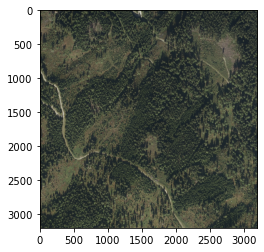

In [10]:
plt.imshow(img_utils.decode_ortho(dataset[i][0:4], 'rgb'))

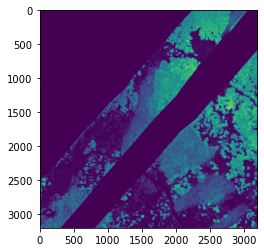

In [11]:
plt.imshow(img_utils.decode_img(dataset[i][4]))

In [12]:
def quatering(dataset, idx_start, idx_end):
    ## prepare input data
    # cut into 4 quaters = 1 x 7x512x512 -> 4 x 7x256x256
    n = idx_end - idx_start
    store = torch.zeros((n*4,7,256,256),dtype=torch.float32)

    for j,i in enumerate(range(idx_start, idx_end)):
        store[j*4] = dataset[i][:,:256,:256]
        store[j*4+1] = dataset[i][:,256:,:256]
        store[j*4+2] = dataset[i][:,:256,256:]
        store[j*4+3] = dataset[i][:,256:,256:] 
    return store

In [13]:
def predict(store):
    # get predictions
    with torch.no_grad():
        output = model(store)
    pred_256 = mgr.get_predictions(output).numpy()
    return pred_256

In [14]:
def merge(pred_256, idx_start, idx_end):
    ## prepare output data
    # merge into 4 quaters = 4 x 256x256 -> 1 x 512x512
    n = idx_end - idx_start
    pred_512 = np.zeros((n,512,512), dtype=np.int8)
    
    for i in range(n):
        j = i*4
        pred_512[i,:256,:256] = pred_256[j]
        pred_512[i,256:,:256] = pred_256[j+1]
        pred_512[i,:256,256:] = pred_256[j+2]
        pred_512[i,256:,256:] = pred_256[j+3]
    return pred_512    

In [16]:
def stack_data(dataset, idx_start, idx_end):
    dl = []
    for i in range(idx_start, idx_end):
        dl.append(dataset[i])
    return torch.stack(dl,0)

In [14]:
def predict(model, input_loader, n_batches=1):
    input_loader.batch_size = 1
    predictions = []
    model.eval()
    for input, target in input_loader:
        data = Variable(input.cuda(), volatile=True)
        label = Variable(target.cuda())
        output = model(data)
        pred = get_predictions(output)
        predictions.append([input,target,pred])
    return predictions

In [17]:
start = 0
end = 782
batch = 1

p = np.zeros((end-start,3200,3200), dtype=np.int8)
print(p.shape)

counter = start

for i in range((end-start) // batch):
    
    print(counter, counter+batch)
    
    #store = quatering(dataset=dataset, idx_start=counter, idx_end=counter+batch)
    store = stack_data(dataset=dataset, idx_start=counter, idx_end=counter+batch)
    store = store.to(device)
    pred_512 = predict(store)
    #pred_512 = pred_512.to('cpu')
    #pred_512 = merge(pred_256, counter, counter+batch)
    
    p[i*batch:(i+1)*batch] = pred_512
    
    counter += batch
    


(782, 3200, 3200)
0 1


/home/philipp/miniconda3/envs/pytorch/lib/python3.8/site-packages/torch/nn/functional.py:2952: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


1 2
2 3
3 4
4 5
5 6
6 7
7 8
8 9
9 10
10 11
11 12
12 13
13 14
14 15
15 16
16 17
17 18
18 19
19 20
20 21
21 22
22 23
23 24
24 25
25 26
26 27
27 28
28 29
29 30
30 31
31 32
32 33
33 34
34 35
35 36
36 37
37 38
38 39
39 40
40 41
41 42
42 43
43 44
44 45
45 46
46 47
47 48
48 49
49 50
50 51
51 52
52 53
53 54
54 55
55 56
56 57
57 58
58 59
59 60
60 61
61 62
62 63
63 64
64 65
65 66
66 67
67 68
68 69
69 70
70 71
71 72
72 73
73 74
74 75
75 76
76 77
77 78
78 79
79 80
80 81
81 82
82 83
83 84
84 85
85 86
86 87
87 88
88 89
89 90
90 91
91 92
92 93
93 94
94 95
95 96
96 97
97 98
98 99
99 100
100 101
101 102
102 103
103 104
104 105
105 106
106 107
107 108
108 109
109 110
110 111
111 112
112 113
113 114
114 115
115 116
116 117
117 118
118 119
119 120
120 121
121 122
122 123
123 124
124 125
125 126
126 127
127 128
128 129
129 130
130 131
131 132
132 133
133 134
134 135
135 136
136 137
137 138
138 139
139 140
140 141
141 142
142 143
143 144
144 145
145 146
146 147
147 148
148 149
149 150
150 151
151 152
152 15

In [18]:
p.shape

(782, 3200, 3200)

In [19]:
#store = stack_data(dataset=dataset, idx_start=10640, idx_end=10660)
#store = store.to(device)
#pred_512 = predict(store)
#p[10640:10660] = pred_512

In [20]:
np.save('pred_deeplab.npy', p)

In [ ]:
##################################################################

In [1]:
## prepare input data
# cut into 4 quaters = 1 x 7x512x512 -> 4 x 7x256x256

start = 0
end = 40

n = end - start
store = torch.zeros((n*4,7,256,256),dtype=torch.float32)

for i,j in enumerate(range(0,n*4,4)):
    store[j] = dataset[i][:,:256,:256]
    store[j+1] = dataset[i][:,256:,:256]
    store[j+2] = dataset[i][:,:256,256:]
    store[j+3] = dataset[i][:,256:,256:]

NameError: name 'torch' is not defined

In [10]:
# get predictions
with torch.no_grad():
    output = model(store)
p = mgr.get_predictions(output).numpy()

In [11]:
p.shape

(160, 256, 256)

In [12]:
## prepare output data
# merge into 4 quaters = 4 x 7x256x256 -> 1 x 7x512x512

pred = np.zeros((n,512,512), dtype=np.int8)

for i,j in enumerate(range(0,n*4,4)):
    pred[i,:256,:256] = p[j]
    pred[i,256:,:256] = p[j+1]
    pred[i,:256,256:] = p[j+2]
    pred[i,256:,256:] = p[j+3]

In [13]:
pred.shape

(40, 512, 512)

In [12]:
mean = 119.50916281232037
std = 49.301477498205074

i = 0
l = 10000
nirs = []

for i in range(20):
    # grab data
    x = torch.stack([dataset[i][3], \
                    dataset[i+1*l][3], \
                    dataset[i+2*l][3], \
                    dataset[i+3*l][3]])
    
    # reconstruct tile
    merged_512 = np.ones((512, 512))
    # paste predicted data into array
    merged_512[:256,:256] = dataset[i][3]
    merged_512[256:,:256] = dataset[i+1*l][3]
    merged_512[:256,256:] = dataset[i+2*l][3]
    merged_512[256:,256:] = dataset[i+3*l][3]
    
    merged_512 = std * merged_512 + mean
    
    nirs.append(merged_512)

In [13]:
nirs = np.array(nirs)

In [15]:
np.save('nir.npy', nirs)

In [16]:
np.save('pred.npy', p)

In [1]:
#########################
## convert to geotiff
#########################

In [1]:
import os
import numpy as np

from osgeo import gdal
from osgeo import gdal_array
from osgeo import osr

In [3]:
def array2raster(newRasterfn, dataset, array, dtype, offsetX=0, offsetY=0):
    """
    save GTiff file from numpy.array
    input:
        newRasterfn: save file name
        dataset : original tif file
        array : numpy.array
        dtype: Byte or Float32.
    """
    cols = array.shape[1]
    rows = array.shape[0]
    originX, pixelWidth, b, originY, d, pixelHeight = dataset.GetGeoTransform()
    originX += offsetX
    originY += offsetY

    driver = gdal.GetDriverByName('GTiff')

    # set data type to save.
    GDT_dtype = gdal.GDT_Unknown
    if dtype == "Byte": 
        GDT_dtype = gdal.GDT_Byte
    elif dtype == "Float32":
        GDT_dtype = gdal.GDT_Float32
    else:
        print("Not supported data type.")

    # set number of band.
    if array.ndim == 2:
        band_num = 1
    else:
        band_num = array.shape[2]

    outRaster = driver.Create(newRasterfn, cols, rows, band_num, GDT_dtype)
    outRaster.SetGeoTransform((originX, pixelWidth, 0, originY, 0, pixelHeight))

    # Loop over all bands.
    for b in range(band_num):
        outband = outRaster.GetRasterBand(b + 1)
        # Read in the band's data into the third dimension of our array
        if band_num == 1:
            outband.WriteArray(array)
        else:
            outband.WriteArray(array[:,:,b])

    # setteing srs from input tif file.
    prj=dataset.GetProjection()
    outRasterSRS = osr.SpatialReference(wkt=prj)
    outRaster.SetProjection(outRasterSRS.ExportToWkt())
    outband.FlushCache()

In [4]:
pred = np.load('pred_deeplab.npy')
#pred = np.load('pred_deeplab.npy')

In [5]:
pred.shape

(782, 3200, 3200)

In [6]:
#########################
### extend 512 to 514 ###
#########################
'''
# create array of 514
pred_p = np.zeros((pred.shape[0], 514, 514),dtype=np.int8)
# set inner part to real data
pred_p[:,1:513,1:513] = pred

# pad rows (copy nearest row)
pred_p[:,0,1:513] = pred[:,0,:]
pred_p[:,-1,1:513] = pred[:,-1,:]
# pad columns (copy nearest row)
pred_p[:,1:513,0] = pred[:,:,0]
pred_p[:,1:513,-1] = pred[:,:,-1]

# fill corners
pred_p[:,0,0] = pred[:,0,0]
pred_p[:,0,-1] = pred[:,0,-1]
pred_p[:,-1,0] = pred[:,-1,0]
pred_p[:,-1,-1] = pred[:,-1,-1]
'''

'\n# create array of 514\npred_p = np.zeros((pred.shape[0], 514, 514),dtype=np.int8)\n# set inner part to real data\npred_p[:,1:513,1:513] = pred\n\n# pad rows (copy nearest row)\npred_p[:,0,1:513] = pred[:,0,:]\npred_p[:,-1,1:513] = pred[:,-1,:]\n# pad columns (copy nearest row)\npred_p[:,1:513,0] = pred[:,:,0]\npred_p[:,1:513,-1] = pred[:,:,-1]\n\n# fill corners\npred_p[:,0,0] = pred[:,0,0]\npred_p[:,0,-1] = pred[:,0,-1]\npred_p[:,-1,0] = pred[:,-1,0]\npred_p[:,-1,-1] = pred[:,-1,-1]\n'

In [7]:
#########################
### extend 3200 to 3100 ###
#########################

pred = pred[:,50:-50,50:-50]

In [8]:
def find_files(dir_img, sort=False):
    """
    find paths for provided data types
    inputs:
        dir_img (str) : directory path
    return:
        paths (dictionary) : dictionary containing file paths for each of the data types
    """

    paths = []
    # loop over all files found in directory and retrive indices
    for file in os.listdir("{}".format(dir_img)):
        if file[-4:] == ".tif":
            paths.append(dir_img + file)

    if sort:
        paths = sorted(paths)
    
    return paths

In [9]:
path_input = find_files('/media/philipp/DATA/2018_tamsweg_pred/ortho/', sort=True)

In [10]:
path_input[0:3]

['/media/philipp/DATA/2018_tamsweg_pred/ortho/tile_ortho_1002.0.tif',
 '/media/philipp/DATA/2018_tamsweg_pred/ortho/tile_ortho_1003.0.tif',
 '/media/philipp/DATA/2018_tamsweg_pred/ortho/tile_ortho_1004.0.tif']

In [11]:
len(path_input)

782

In [12]:
pred.shape[0]

782

In [13]:
for i, path_in in enumerate(path_input[:pred.shape[0]]):
    print(path_in[path_in.rfind('_'):])

_1002.0.tif
_1003.0.tif
_1004.0.tif
_1014.0.tif
_1015.0.tif
_1016.0.tif
_1017.0.tif
_1018.0.tif
_1045.0.tif
_1046.0.tif
_1047.0.tif
_1056.0.tif
_1057.0.tif
_1058.0.tif
_1059.0.tif
_1060.0.tif
_1061.0.tif
_1062.0.tif
_1063.0.tif
_1088.0.tif
_1089.0.tif
_1090.0.tif
_1091.0.tif
_1099.0.tif
_1100.0.tif
_1101.0.tif
_1102.0.tif
_1103.0.tif
_1105.0.tif
_1106.0.tif
_1114.0.tif
_1132.0.tif
_1133.0.tif
_1134.0.tif
_1142.0.tif
_1143.0.tif
_1144.0.tif
_1145.0.tif
_1146.0.tif
_1148.0.tif
_1149.0.tif
_1150.0.tif
_1151.0.tif
_1156.0.tif
_1157.0.tif
_1158.0.tif
_1177.0.tif
_1186.0.tif
_1187.0.tif
_1188.0.tif
_1189.0.tif
_1190.0.tif
_1191.0.tif
_1192.0.tif
_1193.0.tif
_1194.0.tif
_1195.0.tif
_1199.0.tif
_1200.0.tif
_1220.0.tif
_1221.0.tif
_1222.0.tif
_1230.0.tif
_1231.0.tif
_1232.0.tif
_1233.0.tif
_1234.0.tif
_1235.0.tif
_1236.0.tif
_1237.0.tif
_1238.0.tif
_1239.0.tif
_1240.0.tif
_1243.0.tif
_1244.0.tif
_1263.0.tif
_1264.0.tif
_1265.0.tif
_1272.0.tif
_1273.0.tif
_1274.0.tif
_1275.0.tif
_1276.0.tif
_127

In [14]:
# convert numpy array to geotiff files
for i, path_in in enumerate(path_input[:pred.shape[0]]):
    path_out = 'foto/pred{}'.format(path_in[path_in.rfind('_'):])
    dataset = gdal.Open(path_in, gdal.GA_ReadOnly)
    array2raster(newRasterfn=path_out, dataset=dataset, array=pred[i], dtype='Byte')

In [15]:
# mosaik geotiff files

def mosaik_raster(input_files, output_file):
    
    # set path to text file with all tif file paths to be merged
    merge_list_path =  '/home/philipp/Code/python/edin_prediction/dtm_merge_list.txt'
    # create txt file with all tif files needed
    with open(merge_list_path, 'w+') as f:
        for name in input_files:
            f.write(name + '\n')

    # create string containing bash command
    cmd = "gdal_merge.py -ot Byte -of GTiff -o {} --optfile {}".format(output_file, merge_list_path)

    # execute bash command
    os.system(cmd)

    print("DTM file created - files merged")

In [16]:
input_files = find_files('/home/philipp/Code/python/edin_prediction/foto/', sort=True)

In [ ]:
#output_file = '/home/philipp/Code/python/edin_prediction/pred/pred.tif'
output_file = '/media/philipp/DATA/pred_deeplab.tif'
mosaik_raster(input_files, output_file)

In [2]:
output_file = '/media/philipp/DATA/pred_deeplab_177.tif'

In [ ]:
vector_file = '/home/philipp/Code/python/edin_prediction/pred/pred_deeplab_adj_age_3200_2.shp'
# create vector (polygons) out of raster
cmd = 'gdal_polygonize.py -8 {} -b 1 -f "ESRI Shapefile" {} output DF'.format(output_file, vector_file)
# execute bash command
os.system(cmd)

In [26]:
42/160*10679

2803.2375

In [19]:
output_file

'/media/philipp/DATA/pred.tif'

In [1]:
################################################
# confusion matrix
################################################

import os
import numpy as np

from osgeo import gdal
from osgeo import gdal_array
from osgeo import osr

In [3]:
def tif2array(file_path, dtype=np.uint8):
        """
        read GeoTiff and convert to numpy.ndarray.
        inputs:
            file_path (str) : file path of the input GeoTiff file
        return:
            image(np.array) : image for each bands
            dataset : for gdal's data drive
        """
        dataset = gdal.Open(file_path, gdal.GA_ReadOnly)

        if dataset is None:
            return None

        # Allocate our array using the first band's datatype
        image_datatype = dataset.GetRasterBand(1).DataType
        image = np.zeros((dataset.RasterYSize, dataset.RasterXSize, dataset.RasterCount),
                         dtype=dtype)

        # Loop over all bands in dataset
        for b in range(dataset.RasterCount):
            # Remember, GDAL index is on 1, but Python is on 0 -- so we add 1 for our GDAL calls
            band = dataset.GetRasterBand(b + 1)
            # Read in the band's data into the third dimension of our array
            image[:, :, b] = band.ReadAsArray()#buf_type=gdalconst.GDT_Byte)

        #image = image[2:-2,2:-2,:]

        return image

In [4]:
input_files = find_files('/home/philipp/Code/python/edin_prediction/foto/', sort=True)

In [5]:
dir_gt = "/media/philipp/DATA/2018_tamsweg/ground_truth_2/tile_ground_truth"
#y = tif2array("{}{}".format(dir_gt, input_files[0][input_files[0].rfind('_'):]))[1:-2, 1:-2]
#y_hat = tif2array(input_files[0])

In [6]:
d_y = []
#d_y_hat = []

for f in input_files:
    d_y.append(tif2array("{}{}".format(dir_gt, f[f.rfind('_'):]))[1:-2, 1:-2])
    #d_y_hat.append(tif2array(f))
    print(f)

/home/philipp/Code/python/edin_prediction/foto/pred_121889.tif
/home/philipp/Code/python/edin_prediction/foto/pred_121890.tif
/home/philipp/Code/python/edin_prediction/foto/pred_122277.tif
/home/philipp/Code/python/edin_prediction/foto/pred_122278.tif
/home/philipp/Code/python/edin_prediction/foto/pred_122279.tif
/home/philipp/Code/python/edin_prediction/foto/pred_122280.tif
/home/philipp/Code/python/edin_prediction/foto/pred_122647.tif
/home/philipp/Code/python/edin_prediction/foto/pred_122648.tif
/home/philipp/Code/python/edin_prediction/foto/pred_122649.tif
/home/philipp/Code/python/edin_prediction/foto/pred_122650.tif
/home/philipp/Code/python/edin_prediction/foto/pred_122651.tif
/home/philipp/Code/python/edin_prediction/foto/pred_122652.tif
/home/philipp/Code/python/edin_prediction/foto/pred_122653.tif
/home/philipp/Code/python/edin_prediction/foto/pred_123009.tif
/home/philipp/Code/python/edin_prediction/foto/pred_123010.tif
/home/philipp/Code/python/edin_prediction/foto/pred_123

/home/philipp/Code/python/edin_prediction/foto/pred_130427.tif
/home/philipp/Code/python/edin_prediction/foto/pred_130428.tif
/home/philipp/Code/python/edin_prediction/foto/pred_130644.tif
/home/philipp/Code/python/edin_prediction/foto/pred_130645.tif
/home/philipp/Code/python/edin_prediction/foto/pred_130646.tif
/home/philipp/Code/python/edin_prediction/foto/pred_130647.tif
/home/philipp/Code/python/edin_prediction/foto/pred_130862.tif
/home/philipp/Code/python/edin_prediction/foto/pred_130863.tif
/home/philipp/Code/python/edin_prediction/foto/pred_130864.tif
/home/philipp/Code/python/edin_prediction/foto/pred_130865.tif
/home/philipp/Code/python/edin_prediction/foto/pred_130866.tif
/home/philipp/Code/python/edin_prediction/foto/pred_130867.tif
/home/philipp/Code/python/edin_prediction/foto/pred_131076.tif
/home/philipp/Code/python/edin_prediction/foto/pred_131077.tif
/home/philipp/Code/python/edin_prediction/foto/pred_131078.tif
/home/philipp/Code/python/edin_prediction/foto/pred_131

/home/philipp/Code/python/edin_prediction/foto/pred_133701.tif
/home/philipp/Code/python/edin_prediction/foto/pred_133702.tif
/home/philipp/Code/python/edin_prediction/foto/pred_133703.tif
/home/philipp/Code/python/edin_prediction/foto/pred_133704.tif
/home/philipp/Code/python/edin_prediction/foto/pred_133932.tif
/home/philipp/Code/python/edin_prediction/foto/pred_133933.tif
/home/philipp/Code/python/edin_prediction/foto/pred_133934.tif
/home/philipp/Code/python/edin_prediction/foto/pred_133935.tif
/home/philipp/Code/python/edin_prediction/foto/pred_133936.tif
/home/philipp/Code/python/edin_prediction/foto/pred_133937.tif
/home/philipp/Code/python/edin_prediction/foto/pred_133938.tif
/home/philipp/Code/python/edin_prediction/foto/pred_133939.tif
/home/philipp/Code/python/edin_prediction/foto/pred_133940.tif
/home/philipp/Code/python/edin_prediction/foto/pred_133941.tif
/home/philipp/Code/python/edin_prediction/foto/pred_133942.tif
/home/philipp/Code/python/edin_prediction/foto/pred_133

/home/philipp/Code/python/edin_prediction/foto/pred_136871.tif
/home/philipp/Code/python/edin_prediction/foto/pred_136872.tif
/home/philipp/Code/python/edin_prediction/foto/pred_136873.tif
/home/philipp/Code/python/edin_prediction/foto/pred_136874.tif
/home/philipp/Code/python/edin_prediction/foto/pred_136875.tif
/home/philipp/Code/python/edin_prediction/foto/pred_136876.tif
/home/philipp/Code/python/edin_prediction/foto/pred_136877.tif
/home/philipp/Code/python/edin_prediction/foto/pred_137080.tif
/home/philipp/Code/python/edin_prediction/foto/pred_137081.tif
/home/philipp/Code/python/edin_prediction/foto/pred_137082.tif
/home/philipp/Code/python/edin_prediction/foto/pred_137083.tif
/home/philipp/Code/python/edin_prediction/foto/pred_137084.tif
/home/philipp/Code/python/edin_prediction/foto/pred_137085.tif
/home/philipp/Code/python/edin_prediction/foto/pred_137086.tif
/home/philipp/Code/python/edin_prediction/foto/pred_137087.tif
/home/philipp/Code/python/edin_prediction/foto/pred_137

/home/philipp/Code/python/edin_prediction/foto/pred_139705.tif
/home/philipp/Code/python/edin_prediction/foto/pred_139706.tif
/home/philipp/Code/python/edin_prediction/foto/pred_139707.tif
/home/philipp/Code/python/edin_prediction/foto/pred_139708.tif
/home/philipp/Code/python/edin_prediction/foto/pred_139709.tif
/home/philipp/Code/python/edin_prediction/foto/pred_139710.tif
/home/philipp/Code/python/edin_prediction/foto/pred_139711.tif
/home/philipp/Code/python/edin_prediction/foto/pred_139712.tif
/home/philipp/Code/python/edin_prediction/foto/pred_139713.tif
/home/philipp/Code/python/edin_prediction/foto/pred_139714.tif
/home/philipp/Code/python/edin_prediction/foto/pred_139715.tif
/home/philipp/Code/python/edin_prediction/foto/pred_139716.tif
/home/philipp/Code/python/edin_prediction/foto/pred_139717.tif
/home/philipp/Code/python/edin_prediction/foto/pred_139718.tif
/home/philipp/Code/python/edin_prediction/foto/pred_139719.tif
/home/philipp/Code/python/edin_prediction/foto/pred_139

/home/philipp/Code/python/edin_prediction/foto/pred_141838.tif
/home/philipp/Code/python/edin_prediction/foto/pred_141839.tif
/home/philipp/Code/python/edin_prediction/foto/pred_141840.tif
/home/philipp/Code/python/edin_prediction/foto/pred_141841.tif
/home/philipp/Code/python/edin_prediction/foto/pred_141842.tif
/home/philipp/Code/python/edin_prediction/foto/pred_142000.tif
/home/philipp/Code/python/edin_prediction/foto/pred_142001.tif
/home/philipp/Code/python/edin_prediction/foto/pred_142002.tif
/home/philipp/Code/python/edin_prediction/foto/pred_142003.tif
/home/philipp/Code/python/edin_prediction/foto/pred_142004.tif
/home/philipp/Code/python/edin_prediction/foto/pred_142005.tif
/home/philipp/Code/python/edin_prediction/foto/pred_142006.tif
/home/philipp/Code/python/edin_prediction/foto/pred_142007.tif
/home/philipp/Code/python/edin_prediction/foto/pred_142164.tif
/home/philipp/Code/python/edin_prediction/foto/pred_142165.tif
/home/philipp/Code/python/edin_prediction/foto/pred_142

/home/philipp/Code/python/edin_prediction/foto/pred_144425.tif
/home/philipp/Code/python/edin_prediction/foto/pred_144426.tif
/home/philipp/Code/python/edin_prediction/foto/pred_144427.tif
/home/philipp/Code/python/edin_prediction/foto/pred_144428.tif
/home/philipp/Code/python/edin_prediction/foto/pred_144429.tif
/home/philipp/Code/python/edin_prediction/foto/pred_144430.tif
/home/philipp/Code/python/edin_prediction/foto/pred_144431.tif
/home/philipp/Code/python/edin_prediction/foto/pred_144585.tif
/home/philipp/Code/python/edin_prediction/foto/pred_144586.tif
/home/philipp/Code/python/edin_prediction/foto/pred_144587.tif
/home/philipp/Code/python/edin_prediction/foto/pred_144588.tif
/home/philipp/Code/python/edin_prediction/foto/pred_144589.tif
/home/philipp/Code/python/edin_prediction/foto/pred_144590.tif
/home/philipp/Code/python/edin_prediction/foto/pred_144591.tif
/home/philipp/Code/python/edin_prediction/foto/pred_144592.tif
/home/philipp/Code/python/edin_prediction/foto/pred_144

/home/philipp/Code/python/edin_prediction/foto/pred_145740.tif
/home/philipp/Code/python/edin_prediction/foto/pred_145741.tif
/home/philipp/Code/python/edin_prediction/foto/pred_145742.tif
/home/philipp/Code/python/edin_prediction/foto/pred_145743.tif
/home/philipp/Code/python/edin_prediction/foto/pred_145744.tif
/home/philipp/Code/python/edin_prediction/foto/pred_145745.tif
/home/philipp/Code/python/edin_prediction/foto/pred_145877.tif
/home/philipp/Code/python/edin_prediction/foto/pred_145878.tif
/home/philipp/Code/python/edin_prediction/foto/pred_145879.tif
/home/philipp/Code/python/edin_prediction/foto/pred_145880.tif
/home/philipp/Code/python/edin_prediction/foto/pred_145881.tif
/home/philipp/Code/python/edin_prediction/foto/pred_145882.tif
/home/philipp/Code/python/edin_prediction/foto/pred_145883.tif
/home/philipp/Code/python/edin_prediction/foto/pred_145884.tif
/home/philipp/Code/python/edin_prediction/foto/pred_145885.tif
/home/philipp/Code/python/edin_prediction/foto/pred_145

/home/philipp/Code/python/edin_prediction/foto/pred_146760.tif
/home/philipp/Code/python/edin_prediction/foto/pred_146761.tif
/home/philipp/Code/python/edin_prediction/foto/pred_146762.tif
/home/philipp/Code/python/edin_prediction/foto/pred_146763.tif
/home/philipp/Code/python/edin_prediction/foto/pred_146764.tif
/home/philipp/Code/python/edin_prediction/foto/pred_146765.tif
/home/philipp/Code/python/edin_prediction/foto/pred_146766.tif
/home/philipp/Code/python/edin_prediction/foto/pred_146767.tif
/home/philipp/Code/python/edin_prediction/foto/pred_146768.tif
/home/philipp/Code/python/edin_prediction/foto/pred_146769.tif
/home/philipp/Code/python/edin_prediction/foto/pred_146770.tif
/home/philipp/Code/python/edin_prediction/foto/pred_146771.tif
/home/philipp/Code/python/edin_prediction/foto/pred_146772.tif
/home/philipp/Code/python/edin_prediction/foto/pred_146952.tif
/home/philipp/Code/python/edin_prediction/foto/pred_146953.tif
/home/philipp/Code/python/edin_prediction/foto/pred_146

/home/philipp/Code/python/edin_prediction/foto/pred_148017.tif
/home/philipp/Code/python/edin_prediction/foto/pred_148018.tif
/home/philipp/Code/python/edin_prediction/foto/pred_148019.tif
/home/philipp/Code/python/edin_prediction/foto/pred_148020.tif
/home/philipp/Code/python/edin_prediction/foto/pred_148021.tif
/home/philipp/Code/python/edin_prediction/foto/pred_148022.tif
/home/philipp/Code/python/edin_prediction/foto/pred_148023.tif
/home/philipp/Code/python/edin_prediction/foto/pred_148024.tif
/home/philipp/Code/python/edin_prediction/foto/pred_148025.tif
/home/philipp/Code/python/edin_prediction/foto/pred_148026.tif
/home/philipp/Code/python/edin_prediction/foto/pred_148027.tif
/home/philipp/Code/python/edin_prediction/foto/pred_148028.tif
/home/philipp/Code/python/edin_prediction/foto/pred_148029.tif
/home/philipp/Code/python/edin_prediction/foto/pred_148030.tif
/home/philipp/Code/python/edin_prediction/foto/pred_148031.tif
/home/philipp/Code/python/edin_prediction/foto/pred_148

/home/philipp/Code/python/edin_prediction/foto/pred_148932.tif
/home/philipp/Code/python/edin_prediction/foto/pred_148933.tif
/home/philipp/Code/python/edin_prediction/foto/pred_148934.tif
/home/philipp/Code/python/edin_prediction/foto/pred_148935.tif
/home/philipp/Code/python/edin_prediction/foto/pred_148936.tif
/home/philipp/Code/python/edin_prediction/foto/pred_149124.tif
/home/philipp/Code/python/edin_prediction/foto/pred_149125.tif
/home/philipp/Code/python/edin_prediction/foto/pred_149126.tif
/home/philipp/Code/python/edin_prediction/foto/pred_149127.tif
/home/philipp/Code/python/edin_prediction/foto/pred_149128.tif
/home/philipp/Code/python/edin_prediction/foto/pred_149129.tif
/home/philipp/Code/python/edin_prediction/foto/pred_149130.tif
/home/philipp/Code/python/edin_prediction/foto/pred_149131.tif
/home/philipp/Code/python/edin_prediction/foto/pred_149132.tif
/home/philipp/Code/python/edin_prediction/foto/pred_149133.tif
/home/philipp/Code/python/edin_prediction/foto/pred_149

/home/philipp/Code/python/edin_prediction/foto/pred_150387.tif
/home/philipp/Code/python/edin_prediction/foto/pred_150388.tif
/home/philipp/Code/python/edin_prediction/foto/pred_150389.tif
/home/philipp/Code/python/edin_prediction/foto/pred_150390.tif
/home/philipp/Code/python/edin_prediction/foto/pred_150391.tif
/home/philipp/Code/python/edin_prediction/foto/pred_150392.tif
/home/philipp/Code/python/edin_prediction/foto/pred_150393.tif
/home/philipp/Code/python/edin_prediction/foto/pred_150394.tif
/home/philipp/Code/python/edin_prediction/foto/pred_150395.tif
/home/philipp/Code/python/edin_prediction/foto/pred_150396.tif
/home/philipp/Code/python/edin_prediction/foto/pred_150397.tif
/home/philipp/Code/python/edin_prediction/foto/pred_150398.tif
/home/philipp/Code/python/edin_prediction/foto/pred_150399.tif
/home/philipp/Code/python/edin_prediction/foto/pred_150400.tif
/home/philipp/Code/python/edin_prediction/foto/pred_150401.tif
/home/philipp/Code/python/edin_prediction/foto/pred_150

/home/philipp/Code/python/edin_prediction/foto/pred_151362.tif
/home/philipp/Code/python/edin_prediction/foto/pred_151363.tif
/home/philipp/Code/python/edin_prediction/foto/pred_151364.tif
/home/philipp/Code/python/edin_prediction/foto/pred_151365.tif
/home/philipp/Code/python/edin_prediction/foto/pred_151366.tif
/home/philipp/Code/python/edin_prediction/foto/pred_151367.tif
/home/philipp/Code/python/edin_prediction/foto/pred_151368.tif
/home/philipp/Code/python/edin_prediction/foto/pred_151369.tif
/home/philipp/Code/python/edin_prediction/foto/pred_151370.tif
/home/philipp/Code/python/edin_prediction/foto/pred_151371.tif
/home/philipp/Code/python/edin_prediction/foto/pred_151372.tif
/home/philipp/Code/python/edin_prediction/foto/pred_151373.tif
/home/philipp/Code/python/edin_prediction/foto/pred_151374.tif
/home/philipp/Code/python/edin_prediction/foto/pred_151375.tif
/home/philipp/Code/python/edin_prediction/foto/pred_151376.tif
/home/philipp/Code/python/edin_prediction/foto/pred_151

/home/philipp/Code/python/edin_prediction/foto/pred_152371.tif
/home/philipp/Code/python/edin_prediction/foto/pred_152372.tif
/home/philipp/Code/python/edin_prediction/foto/pred_152373.tif
/home/philipp/Code/python/edin_prediction/foto/pred_152374.tif
/home/philipp/Code/python/edin_prediction/foto/pred_152375.tif
/home/philipp/Code/python/edin_prediction/foto/pred_152376.tif
/home/philipp/Code/python/edin_prediction/foto/pred_152377.tif
/home/philipp/Code/python/edin_prediction/foto/pred_152378.tif
/home/philipp/Code/python/edin_prediction/foto/pred_152379.tif
/home/philipp/Code/python/edin_prediction/foto/pred_152380.tif
/home/philipp/Code/python/edin_prediction/foto/pred_152381.tif
/home/philipp/Code/python/edin_prediction/foto/pred_152382.tif
/home/philipp/Code/python/edin_prediction/foto/pred_152383.tif
/home/philipp/Code/python/edin_prediction/foto/pred_152384.tif
/home/philipp/Code/python/edin_prediction/foto/pred_152385.tif
/home/philipp/Code/python/edin_prediction/foto/pred_152

/home/philipp/Code/python/edin_prediction/foto/pred_153067.tif
/home/philipp/Code/python/edin_prediction/foto/pred_153068.tif
/home/philipp/Code/python/edin_prediction/foto/pred_153069.tif
/home/philipp/Code/python/edin_prediction/foto/pred_153070.tif
/home/philipp/Code/python/edin_prediction/foto/pred_153071.tif
/home/philipp/Code/python/edin_prediction/foto/pred_153072.tif
/home/philipp/Code/python/edin_prediction/foto/pred_153073.tif
/home/philipp/Code/python/edin_prediction/foto/pred_153074.tif
/home/philipp/Code/python/edin_prediction/foto/pred_153075.tif
/home/philipp/Code/python/edin_prediction/foto/pred_153076.tif
/home/philipp/Code/python/edin_prediction/foto/pred_153077.tif
/home/philipp/Code/python/edin_prediction/foto/pred_153078.tif
/home/philipp/Code/python/edin_prediction/foto/pred_153079.tif
/home/philipp/Code/python/edin_prediction/foto/pred_153080.tif
/home/philipp/Code/python/edin_prediction/foto/pred_153081.tif
/home/philipp/Code/python/edin_prediction/foto/pred_153

/home/philipp/Code/python/edin_prediction/foto/pred_153833.tif
/home/philipp/Code/python/edin_prediction/foto/pred_153834.tif
/home/philipp/Code/python/edin_prediction/foto/pred_153835.tif
/home/philipp/Code/python/edin_prediction/foto/pred_153836.tif
/home/philipp/Code/python/edin_prediction/foto/pred_153837.tif
/home/philipp/Code/python/edin_prediction/foto/pred_153838.tif
/home/philipp/Code/python/edin_prediction/foto/pred_153839.tif
/home/philipp/Code/python/edin_prediction/foto/pred_153840.tif
/home/philipp/Code/python/edin_prediction/foto/pred_153841.tif
/home/philipp/Code/python/edin_prediction/foto/pred_153842.tif
/home/philipp/Code/python/edin_prediction/foto/pred_153843.tif
/home/philipp/Code/python/edin_prediction/foto/pred_153844.tif
/home/philipp/Code/python/edin_prediction/foto/pred_153845.tif
/home/philipp/Code/python/edin_prediction/foto/pred_153846.tif
/home/philipp/Code/python/edin_prediction/foto/pred_153847.tif
/home/philipp/Code/python/edin_prediction/foto/pred_153

/home/philipp/Code/python/edin_prediction/foto/pred_154568.tif
/home/philipp/Code/python/edin_prediction/foto/pred_154569.tif
/home/philipp/Code/python/edin_prediction/foto/pred_154570.tif
/home/philipp/Code/python/edin_prediction/foto/pred_154571.tif
/home/philipp/Code/python/edin_prediction/foto/pred_154572.tif
/home/philipp/Code/python/edin_prediction/foto/pred_154573.tif
/home/philipp/Code/python/edin_prediction/foto/pred_154574.tif
/home/philipp/Code/python/edin_prediction/foto/pred_154575.tif
/home/philipp/Code/python/edin_prediction/foto/pred_154576.tif
/home/philipp/Code/python/edin_prediction/foto/pred_154577.tif
/home/philipp/Code/python/edin_prediction/foto/pred_154784.tif
/home/philipp/Code/python/edin_prediction/foto/pred_154785.tif
/home/philipp/Code/python/edin_prediction/foto/pred_154786.tif
/home/philipp/Code/python/edin_prediction/foto/pred_154787.tif
/home/philipp/Code/python/edin_prediction/foto/pred_154788.tif
/home/philipp/Code/python/edin_prediction/foto/pred_154

/home/philipp/Code/python/edin_prediction/foto/pred_155515.tif
/home/philipp/Code/python/edin_prediction/foto/pred_155516.tif
/home/philipp/Code/python/edin_prediction/foto/pred_155517.tif
/home/philipp/Code/python/edin_prediction/foto/pred_155518.tif
/home/philipp/Code/python/edin_prediction/foto/pred_155519.tif
/home/philipp/Code/python/edin_prediction/foto/pred_155520.tif
/home/philipp/Code/python/edin_prediction/foto/pred_155521.tif
/home/philipp/Code/python/edin_prediction/foto/pred_155522.tif
/home/philipp/Code/python/edin_prediction/foto/pred_155523.tif
/home/philipp/Code/python/edin_prediction/foto/pred_155524.tif
/home/philipp/Code/python/edin_prediction/foto/pred_155525.tif
/home/philipp/Code/python/edin_prediction/foto/pred_155526.tif
/home/philipp/Code/python/edin_prediction/foto/pred_155527.tif
/home/philipp/Code/python/edin_prediction/foto/pred_155528.tif
/home/philipp/Code/python/edin_prediction/foto/pred_155529.tif
/home/philipp/Code/python/edin_prediction/foto/pred_155

/home/philipp/Code/python/edin_prediction/foto/pred_156474.tif
/home/philipp/Code/python/edin_prediction/foto/pred_156475.tif
/home/philipp/Code/python/edin_prediction/foto/pred_156476.tif
/home/philipp/Code/python/edin_prediction/foto/pred_156477.tif
/home/philipp/Code/python/edin_prediction/foto/pred_156478.tif
/home/philipp/Code/python/edin_prediction/foto/pred_156479.tif
/home/philipp/Code/python/edin_prediction/foto/pred_156480.tif
/home/philipp/Code/python/edin_prediction/foto/pred_156481.tif
/home/philipp/Code/python/edin_prediction/foto/pred_156482.tif
/home/philipp/Code/python/edin_prediction/foto/pred_156483.tif
/home/philipp/Code/python/edin_prediction/foto/pred_156484.tif
/home/philipp/Code/python/edin_prediction/foto/pred_156485.tif
/home/philipp/Code/python/edin_prediction/foto/pred_156486.tif
/home/philipp/Code/python/edin_prediction/foto/pred_156487.tif
/home/philipp/Code/python/edin_prediction/foto/pred_156488.tif
/home/philipp/Code/python/edin_prediction/foto/pred_156

/home/philipp/Code/python/edin_prediction/foto/pred_157636.tif
/home/philipp/Code/python/edin_prediction/foto/pred_157637.tif
/home/philipp/Code/python/edin_prediction/foto/pred_157638.tif
/home/philipp/Code/python/edin_prediction/foto/pred_157639.tif
/home/philipp/Code/python/edin_prediction/foto/pred_157640.tif
/home/philipp/Code/python/edin_prediction/foto/pred_157641.tif
/home/philipp/Code/python/edin_prediction/foto/pred_157642.tif
/home/philipp/Code/python/edin_prediction/foto/pred_157643.tif
/home/philipp/Code/python/edin_prediction/foto/pred_157644.tif
/home/philipp/Code/python/edin_prediction/foto/pred_157645.tif
/home/philipp/Code/python/edin_prediction/foto/pred_157646.tif
/home/philipp/Code/python/edin_prediction/foto/pred_157647.tif
/home/philipp/Code/python/edin_prediction/foto/pred_157648.tif
/home/philipp/Code/python/edin_prediction/foto/pred_157649.tif
/home/philipp/Code/python/edin_prediction/foto/pred_157650.tif
/home/philipp/Code/python/edin_prediction/foto/pred_157

/home/philipp/Code/python/edin_prediction/foto/pred_158745.tif
/home/philipp/Code/python/edin_prediction/foto/pred_158746.tif
/home/philipp/Code/python/edin_prediction/foto/pred_158747.tif
/home/philipp/Code/python/edin_prediction/foto/pred_158935.tif
/home/philipp/Code/python/edin_prediction/foto/pred_158936.tif
/home/philipp/Code/python/edin_prediction/foto/pred_158937.tif
/home/philipp/Code/python/edin_prediction/foto/pred_158938.tif
/home/philipp/Code/python/edin_prediction/foto/pred_158939.tif
/home/philipp/Code/python/edin_prediction/foto/pred_158940.tif
/home/philipp/Code/python/edin_prediction/foto/pred_158941.tif
/home/philipp/Code/python/edin_prediction/foto/pred_158942.tif
/home/philipp/Code/python/edin_prediction/foto/pred_158943.tif
/home/philipp/Code/python/edin_prediction/foto/pred_158944.tif
/home/philipp/Code/python/edin_prediction/foto/pred_158945.tif
/home/philipp/Code/python/edin_prediction/foto/pred_158946.tif
/home/philipp/Code/python/edin_prediction/foto/pred_158

/home/philipp/Code/python/edin_prediction/foto/pred_160171.tif
/home/philipp/Code/python/edin_prediction/foto/pred_160172.tif
/home/philipp/Code/python/edin_prediction/foto/pred_160173.tif
/home/philipp/Code/python/edin_prediction/foto/pred_160174.tif
/home/philipp/Code/python/edin_prediction/foto/pred_160175.tif
/home/philipp/Code/python/edin_prediction/foto/pred_160176.tif
/home/philipp/Code/python/edin_prediction/foto/pred_160177.tif
/home/philipp/Code/python/edin_prediction/foto/pred_160178.tif
/home/philipp/Code/python/edin_prediction/foto/pred_160179.tif
/home/philipp/Code/python/edin_prediction/foto/pred_160180.tif
/home/philipp/Code/python/edin_prediction/foto/pred_160181.tif
/home/philipp/Code/python/edin_prediction/foto/pred_160182.tif
/home/philipp/Code/python/edin_prediction/foto/pred_160183.tif
/home/philipp/Code/python/edin_prediction/foto/pred_160184.tif
/home/philipp/Code/python/edin_prediction/foto/pred_160185.tif
/home/philipp/Code/python/edin_prediction/foto/pred_160

/home/philipp/Code/python/edin_prediction/foto/pred_160911.tif
/home/philipp/Code/python/edin_prediction/foto/pred_160912.tif
/home/philipp/Code/python/edin_prediction/foto/pred_160913.tif
/home/philipp/Code/python/edin_prediction/foto/pred_160914.tif
/home/philipp/Code/python/edin_prediction/foto/pred_160915.tif
/home/philipp/Code/python/edin_prediction/foto/pred_160916.tif
/home/philipp/Code/python/edin_prediction/foto/pred_160917.tif
/home/philipp/Code/python/edin_prediction/foto/pred_160918.tif
/home/philipp/Code/python/edin_prediction/foto/pred_160919.tif
/home/philipp/Code/python/edin_prediction/foto/pred_160920.tif
/home/philipp/Code/python/edin_prediction/foto/pred_160921.tif
/home/philipp/Code/python/edin_prediction/foto/pred_160922.tif
/home/philipp/Code/python/edin_prediction/foto/pred_160923.tif
/home/philipp/Code/python/edin_prediction/foto/pred_160924.tif
/home/philipp/Code/python/edin_prediction/foto/pred_160925.tif
/home/philipp/Code/python/edin_prediction/foto/pred_160

/home/philipp/Code/python/edin_prediction/foto/pred_161478.tif
/home/philipp/Code/python/edin_prediction/foto/pred_161479.tif
/home/philipp/Code/python/edin_prediction/foto/pred_161480.tif
/home/philipp/Code/python/edin_prediction/foto/pred_161481.tif
/home/philipp/Code/python/edin_prediction/foto/pred_161482.tif
/home/philipp/Code/python/edin_prediction/foto/pred_161483.tif
/home/philipp/Code/python/edin_prediction/foto/pred_161484.tif
/home/philipp/Code/python/edin_prediction/foto/pred_161485.tif
/home/philipp/Code/python/edin_prediction/foto/pred_161486.tif
/home/philipp/Code/python/edin_prediction/foto/pred_161487.tif
/home/philipp/Code/python/edin_prediction/foto/pred_161488.tif
/home/philipp/Code/python/edin_prediction/foto/pred_161489.tif
/home/philipp/Code/python/edin_prediction/foto/pred_161490.tif
/home/philipp/Code/python/edin_prediction/foto/pred_161491.tif
/home/philipp/Code/python/edin_prediction/foto/pred_161492.tif
/home/philipp/Code/python/edin_prediction/foto/pred_161

/home/philipp/Code/python/edin_prediction/foto/pred_162379.tif
/home/philipp/Code/python/edin_prediction/foto/pred_162380.tif
/home/philipp/Code/python/edin_prediction/foto/pred_162381.tif
/home/philipp/Code/python/edin_prediction/foto/pred_162382.tif
/home/philipp/Code/python/edin_prediction/foto/pred_162383.tif
/home/philipp/Code/python/edin_prediction/foto/pred_162384.tif
/home/philipp/Code/python/edin_prediction/foto/pred_162385.tif
/home/philipp/Code/python/edin_prediction/foto/pred_162386.tif
/home/philipp/Code/python/edin_prediction/foto/pred_162387.tif
/home/philipp/Code/python/edin_prediction/foto/pred_162388.tif
/home/philipp/Code/python/edin_prediction/foto/pred_162389.tif
/home/philipp/Code/python/edin_prediction/foto/pred_162390.tif
/home/philipp/Code/python/edin_prediction/foto/pred_162391.tif
/home/philipp/Code/python/edin_prediction/foto/pred_162392.tif
/home/philipp/Code/python/edin_prediction/foto/pred_162393.tif
/home/philipp/Code/python/edin_prediction/foto/pred_162

/home/philipp/Code/python/edin_prediction/foto/pred_163262.tif
/home/philipp/Code/python/edin_prediction/foto/pred_163263.tif
/home/philipp/Code/python/edin_prediction/foto/pred_163264.tif
/home/philipp/Code/python/edin_prediction/foto/pred_163265.tif
/home/philipp/Code/python/edin_prediction/foto/pred_163266.tif
/home/philipp/Code/python/edin_prediction/foto/pred_163267.tif
/home/philipp/Code/python/edin_prediction/foto/pred_163268.tif
/home/philipp/Code/python/edin_prediction/foto/pred_163269.tif
/home/philipp/Code/python/edin_prediction/foto/pred_163270.tif
/home/philipp/Code/python/edin_prediction/foto/pred_163271.tif
/home/philipp/Code/python/edin_prediction/foto/pred_163272.tif
/home/philipp/Code/python/edin_prediction/foto/pred_163273.tif
/home/philipp/Code/python/edin_prediction/foto/pred_163274.tif
/home/philipp/Code/python/edin_prediction/foto/pred_163275.tif
/home/philipp/Code/python/edin_prediction/foto/pred_163276.tif
/home/philipp/Code/python/edin_prediction/foto/pred_163

/home/philipp/Code/python/edin_prediction/foto/pred_163986.tif
/home/philipp/Code/python/edin_prediction/foto/pred_163987.tif
/home/philipp/Code/python/edin_prediction/foto/pred_163988.tif
/home/philipp/Code/python/edin_prediction/foto/pred_163989.tif
/home/philipp/Code/python/edin_prediction/foto/pred_163990.tif
/home/philipp/Code/python/edin_prediction/foto/pred_163991.tif
/home/philipp/Code/python/edin_prediction/foto/pred_163992.tif
/home/philipp/Code/python/edin_prediction/foto/pred_163993.tif
/home/philipp/Code/python/edin_prediction/foto/pred_163994.tif
/home/philipp/Code/python/edin_prediction/foto/pred_163995.tif
/home/philipp/Code/python/edin_prediction/foto/pred_163996.tif
/home/philipp/Code/python/edin_prediction/foto/pred_163997.tif
/home/philipp/Code/python/edin_prediction/foto/pred_163998.tif
/home/philipp/Code/python/edin_prediction/foto/pred_163999.tif
/home/philipp/Code/python/edin_prediction/foto/pred_164000.tif
/home/philipp/Code/python/edin_prediction/foto/pred_164

/home/philipp/Code/python/edin_prediction/foto/pred_164758.tif
/home/philipp/Code/python/edin_prediction/foto/pred_164759.tif
/home/philipp/Code/python/edin_prediction/foto/pred_164760.tif
/home/philipp/Code/python/edin_prediction/foto/pred_164761.tif
/home/philipp/Code/python/edin_prediction/foto/pred_164762.tif
/home/philipp/Code/python/edin_prediction/foto/pred_164763.tif
/home/philipp/Code/python/edin_prediction/foto/pred_164764.tif
/home/philipp/Code/python/edin_prediction/foto/pred_164765.tif
/home/philipp/Code/python/edin_prediction/foto/pred_164766.tif
/home/philipp/Code/python/edin_prediction/foto/pred_164767.tif
/home/philipp/Code/python/edin_prediction/foto/pred_164768.tif
/home/philipp/Code/python/edin_prediction/foto/pred_164769.tif
/home/philipp/Code/python/edin_prediction/foto/pred_164770.tif
/home/philipp/Code/python/edin_prediction/foto/pred_164771.tif
/home/philipp/Code/python/edin_prediction/foto/pred_164772.tif
/home/philipp/Code/python/edin_prediction/foto/pred_164

/home/philipp/Code/python/edin_prediction/foto/pred_165366.tif
/home/philipp/Code/python/edin_prediction/foto/pred_165367.tif
/home/philipp/Code/python/edin_prediction/foto/pred_165368.tif
/home/philipp/Code/python/edin_prediction/foto/pred_165369.tif
/home/philipp/Code/python/edin_prediction/foto/pred_165370.tif
/home/philipp/Code/python/edin_prediction/foto/pred_165371.tif
/home/philipp/Code/python/edin_prediction/foto/pred_165372.tif
/home/philipp/Code/python/edin_prediction/foto/pred_165373.tif
/home/philipp/Code/python/edin_prediction/foto/pred_165374.tif
/home/philipp/Code/python/edin_prediction/foto/pred_165375.tif
/home/philipp/Code/python/edin_prediction/foto/pred_165376.tif
/home/philipp/Code/python/edin_prediction/foto/pred_165377.tif
/home/philipp/Code/python/edin_prediction/foto/pred_165378.tif
/home/philipp/Code/python/edin_prediction/foto/pred_165379.tif
/home/philipp/Code/python/edin_prediction/foto/pred_165380.tif
/home/philipp/Code/python/edin_prediction/foto/pred_165

/home/philipp/Code/python/edin_prediction/foto/pred_166214.tif
/home/philipp/Code/python/edin_prediction/foto/pred_166215.tif
/home/philipp/Code/python/edin_prediction/foto/pred_166216.tif
/home/philipp/Code/python/edin_prediction/foto/pred_166217.tif
/home/philipp/Code/python/edin_prediction/foto/pred_166218.tif
/home/philipp/Code/python/edin_prediction/foto/pred_166219.tif
/home/philipp/Code/python/edin_prediction/foto/pred_166220.tif
/home/philipp/Code/python/edin_prediction/foto/pred_166221.tif
/home/philipp/Code/python/edin_prediction/foto/pred_166222.tif
/home/philipp/Code/python/edin_prediction/foto/pred_166223.tif
/home/philipp/Code/python/edin_prediction/foto/pred_166224.tif
/home/philipp/Code/python/edin_prediction/foto/pred_166225.tif
/home/philipp/Code/python/edin_prediction/foto/pred_166226.tif
/home/philipp/Code/python/edin_prediction/foto/pred_166227.tif
/home/philipp/Code/python/edin_prediction/foto/pred_166228.tif
/home/philipp/Code/python/edin_prediction/foto/pred_166

/home/philipp/Code/python/edin_prediction/foto/pred_167093.tif
/home/philipp/Code/python/edin_prediction/foto/pred_167094.tif
/home/philipp/Code/python/edin_prediction/foto/pred_167095.tif
/home/philipp/Code/python/edin_prediction/foto/pred_167096.tif
/home/philipp/Code/python/edin_prediction/foto/pred_167097.tif
/home/philipp/Code/python/edin_prediction/foto/pred_167098.tif
/home/philipp/Code/python/edin_prediction/foto/pred_167099.tif
/home/philipp/Code/python/edin_prediction/foto/pred_167100.tif
/home/philipp/Code/python/edin_prediction/foto/pred_167101.tif
/home/philipp/Code/python/edin_prediction/foto/pred_167102.tif
/home/philipp/Code/python/edin_prediction/foto/pred_167103.tif
/home/philipp/Code/python/edin_prediction/foto/pred_167104.tif
/home/philipp/Code/python/edin_prediction/foto/pred_167105.tif
/home/philipp/Code/python/edin_prediction/foto/pred_167106.tif
/home/philipp/Code/python/edin_prediction/foto/pred_167107.tif
/home/philipp/Code/python/edin_prediction/foto/pred_167

/home/philipp/Code/python/edin_prediction/foto/pred_167986.tif
/home/philipp/Code/python/edin_prediction/foto/pred_167987.tif
/home/philipp/Code/python/edin_prediction/foto/pred_167988.tif
/home/philipp/Code/python/edin_prediction/foto/pred_167989.tif
/home/philipp/Code/python/edin_prediction/foto/pred_167990.tif
/home/philipp/Code/python/edin_prediction/foto/pred_167991.tif
/home/philipp/Code/python/edin_prediction/foto/pred_167992.tif
/home/philipp/Code/python/edin_prediction/foto/pred_167993.tif
/home/philipp/Code/python/edin_prediction/foto/pred_167994.tif
/home/philipp/Code/python/edin_prediction/foto/pred_167995.tif
/home/philipp/Code/python/edin_prediction/foto/pred_167996.tif
/home/philipp/Code/python/edin_prediction/foto/pred_168243.tif
/home/philipp/Code/python/edin_prediction/foto/pred_168244.tif
/home/philipp/Code/python/edin_prediction/foto/pred_168245.tif
/home/philipp/Code/python/edin_prediction/foto/pred_168246.tif
/home/philipp/Code/python/edin_prediction/foto/pred_168

/home/philipp/Code/python/edin_prediction/foto/pred_169366.tif
/home/philipp/Code/python/edin_prediction/foto/pred_169367.tif
/home/philipp/Code/python/edin_prediction/foto/pred_169368.tif
/home/philipp/Code/python/edin_prediction/foto/pred_169369.tif
/home/philipp/Code/python/edin_prediction/foto/pred_169370.tif
/home/philipp/Code/python/edin_prediction/foto/pred_169371.tif
/home/philipp/Code/python/edin_prediction/foto/pred_169372.tif
/home/philipp/Code/python/edin_prediction/foto/pred_169373.tif
/home/philipp/Code/python/edin_prediction/foto/pred_169374.tif
/home/philipp/Code/python/edin_prediction/foto/pred_169375.tif
/home/philipp/Code/python/edin_prediction/foto/pred_169376.tif
/home/philipp/Code/python/edin_prediction/foto/pred_169377.tif
/home/philipp/Code/python/edin_prediction/foto/pred_169378.tif
/home/philipp/Code/python/edin_prediction/foto/pred_169379.tif
/home/philipp/Code/python/edin_prediction/foto/pred_169380.tif
/home/philipp/Code/python/edin_prediction/foto/pred_169

/home/philipp/Code/python/edin_prediction/foto/pred_171414.tif
/home/philipp/Code/python/edin_prediction/foto/pred_171415.tif
/home/philipp/Code/python/edin_prediction/foto/pred_171416.tif
/home/philipp/Code/python/edin_prediction/foto/pred_171417.tif
/home/philipp/Code/python/edin_prediction/foto/pred_171418.tif
/home/philipp/Code/python/edin_prediction/foto/pred_171419.tif
/home/philipp/Code/python/edin_prediction/foto/pred_171420.tif
/home/philipp/Code/python/edin_prediction/foto/pred_171421.tif
/home/philipp/Code/python/edin_prediction/foto/pred_171422.tif
/home/philipp/Code/python/edin_prediction/foto/pred_171423.tif
/home/philipp/Code/python/edin_prediction/foto/pred_171424.tif
/home/philipp/Code/python/edin_prediction/foto/pred_171425.tif
/home/philipp/Code/python/edin_prediction/foto/pred_171426.tif
/home/philipp/Code/python/edin_prediction/foto/pred_171427.tif
/home/philipp/Code/python/edin_prediction/foto/pred_171428.tif
/home/philipp/Code/python/edin_prediction/foto/pred_171

/home/philipp/Code/python/edin_prediction/foto/pred_176216.tif
/home/philipp/Code/python/edin_prediction/foto/pred_176391.tif
/home/philipp/Code/python/edin_prediction/foto/pred_176392.tif
/home/philipp/Code/python/edin_prediction/foto/pred_176393.tif
/home/philipp/Code/python/edin_prediction/foto/pred_176394.tif
/home/philipp/Code/python/edin_prediction/foto/pred_176395.tif
/home/philipp/Code/python/edin_prediction/foto/pred_176396.tif
/home/philipp/Code/python/edin_prediction/foto/pred_176397.tif
/home/philipp/Code/python/edin_prediction/foto/pred_176398.tif
/home/philipp/Code/python/edin_prediction/foto/pred_176399.tif
/home/philipp/Code/python/edin_prediction/foto/pred_176579.tif
/home/philipp/Code/python/edin_prediction/foto/pred_176580.tif
/home/philipp/Code/python/edin_prediction/foto/pred_176581.tif
/home/philipp/Code/python/edin_prediction/foto/pred_176582.tif
/home/philipp/Code/python/edin_prediction/foto/pred_176583.tif
/home/philipp/Code/python/edin_prediction/foto/pred_176

/home/philipp/Code/python/edin_prediction/foto/pred_180204.tif
/home/philipp/Code/python/edin_prediction/foto/pred_180205.tif
/home/philipp/Code/python/edin_prediction/foto/pred_180206.tif
/home/philipp/Code/python/edin_prediction/foto/pred_180207.tif
/home/philipp/Code/python/edin_prediction/foto/pred_180208.tif
/home/philipp/Code/python/edin_prediction/foto/pred_180209.tif
/home/philipp/Code/python/edin_prediction/foto/pred_180210.tif
/home/philipp/Code/python/edin_prediction/foto/pred_180211.tif
/home/philipp/Code/python/edin_prediction/foto/pred_180212.tif
/home/philipp/Code/python/edin_prediction/foto/pred_180213.tif
/home/philipp/Code/python/edin_prediction/foto/pred_180214.tif
/home/philipp/Code/python/edin_prediction/foto/pred_180215.tif
/home/philipp/Code/python/edin_prediction/foto/pred_180216.tif
/home/philipp/Code/python/edin_prediction/foto/pred_180362.tif
/home/philipp/Code/python/edin_prediction/foto/pred_180363.tif
/home/philipp/Code/python/edin_prediction/foto/pred_180

/home/philipp/Code/python/edin_prediction/foto/pred_181945.tif
/home/philipp/Code/python/edin_prediction/foto/pred_181946.tif
/home/philipp/Code/python/edin_prediction/foto/pred_181947.tif
/home/philipp/Code/python/edin_prediction/foto/pred_181948.tif
/home/philipp/Code/python/edin_prediction/foto/pred_181949.tif
/home/philipp/Code/python/edin_prediction/foto/pred_181950.tif
/home/philipp/Code/python/edin_prediction/foto/pred_181951.tif
/home/philipp/Code/python/edin_prediction/foto/pred_181952.tif
/home/philipp/Code/python/edin_prediction/foto/pred_181953.tif
/home/philipp/Code/python/edin_prediction/foto/pred_181954.tif
/home/philipp/Code/python/edin_prediction/foto/pred_181955.tif
/home/philipp/Code/python/edin_prediction/foto/pred_181956.tif
/home/philipp/Code/python/edin_prediction/foto/pred_181957.tif
/home/philipp/Code/python/edin_prediction/foto/pred_181958.tif
/home/philipp/Code/python/edin_prediction/foto/pred_182075.tif
/home/philipp/Code/python/edin_prediction/foto/pred_182

/home/philipp/Code/python/edin_prediction/foto/pred_183003.tif
/home/philipp/Code/python/edin_prediction/foto/pred_183004.tif
/home/philipp/Code/python/edin_prediction/foto/pred_183005.tif
/home/philipp/Code/python/edin_prediction/foto/pred_183006.tif
/home/philipp/Code/python/edin_prediction/foto/pred_183007.tif
/home/philipp/Code/python/edin_prediction/foto/pred_183008.tif
/home/philipp/Code/python/edin_prediction/foto/pred_183126.tif
/home/philipp/Code/python/edin_prediction/foto/pred_183127.tif
/home/philipp/Code/python/edin_prediction/foto/pred_183128.tif
/home/philipp/Code/python/edin_prediction/foto/pred_183129.tif
/home/philipp/Code/python/edin_prediction/foto/pred_183130.tif
/home/philipp/Code/python/edin_prediction/foto/pred_183131.tif
/home/philipp/Code/python/edin_prediction/foto/pred_183132.tif
/home/philipp/Code/python/edin_prediction/foto/pred_183133.tif
/home/philipp/Code/python/edin_prediction/foto/pred_183134.tif
/home/philipp/Code/python/edin_prediction/foto/pred_183

/home/philipp/Code/python/edin_prediction/foto/pred_183695.tif
/home/philipp/Code/python/edin_prediction/foto/pred_183696.tif
/home/philipp/Code/python/edin_prediction/foto/pred_183697.tif
/home/philipp/Code/python/edin_prediction/foto/pred_183698.tif
/home/philipp/Code/python/edin_prediction/foto/pred_183699.tif
/home/philipp/Code/python/edin_prediction/foto/pred_183700.tif
/home/philipp/Code/python/edin_prediction/foto/pred_183701.tif
/home/philipp/Code/python/edin_prediction/foto/pred_183702.tif
/home/philipp/Code/python/edin_prediction/foto/pred_183703.tif
/home/philipp/Code/python/edin_prediction/foto/pred_183704.tif
/home/philipp/Code/python/edin_prediction/foto/pred_183705.tif
/home/philipp/Code/python/edin_prediction/foto/pred_183706.tif
/home/philipp/Code/python/edin_prediction/foto/pred_183707.tif
/home/philipp/Code/python/edin_prediction/foto/pred_183708.tif
/home/philipp/Code/python/edin_prediction/foto/pred_183709.tif
/home/philipp/Code/python/edin_prediction/foto/pred_183

/home/philipp/Code/python/edin_prediction/foto/pred_184741.tif
/home/philipp/Code/python/edin_prediction/foto/pred_184742.tif
/home/philipp/Code/python/edin_prediction/foto/pred_184743.tif
/home/philipp/Code/python/edin_prediction/foto/pred_184744.tif
/home/philipp/Code/python/edin_prediction/foto/pred_184745.tif
/home/philipp/Code/python/edin_prediction/foto/pred_184746.tif
/home/philipp/Code/python/edin_prediction/foto/pred_184747.tif
/home/philipp/Code/python/edin_prediction/foto/pred_184748.tif
/home/philipp/Code/python/edin_prediction/foto/pred_184749.tif
/home/philipp/Code/python/edin_prediction/foto/pred_184750.tif
/home/philipp/Code/python/edin_prediction/foto/pred_184751.tif
/home/philipp/Code/python/edin_prediction/foto/pred_184752.tif
/home/philipp/Code/python/edin_prediction/foto/pred_184753.tif
/home/philipp/Code/python/edin_prediction/foto/pred_184754.tif
/home/philipp/Code/python/edin_prediction/foto/pred_184755.tif
/home/philipp/Code/python/edin_prediction/foto/pred_184

/home/philipp/Code/python/edin_prediction/foto/pred_185278.tif
/home/philipp/Code/python/edin_prediction/foto/pred_185279.tif
/home/philipp/Code/python/edin_prediction/foto/pred_185280.tif
/home/philipp/Code/python/edin_prediction/foto/pred_185281.tif
/home/philipp/Code/python/edin_prediction/foto/pred_185282.tif
/home/philipp/Code/python/edin_prediction/foto/pred_185283.tif
/home/philipp/Code/python/edin_prediction/foto/pred_185284.tif
/home/philipp/Code/python/edin_prediction/foto/pred_185285.tif
/home/philipp/Code/python/edin_prediction/foto/pred_185286.tif
/home/philipp/Code/python/edin_prediction/foto/pred_185287.tif
/home/philipp/Code/python/edin_prediction/foto/pred_185288.tif
/home/philipp/Code/python/edin_prediction/foto/pred_185289.tif
/home/philipp/Code/python/edin_prediction/foto/pred_185290.tif
/home/philipp/Code/python/edin_prediction/foto/pred_185291.tif
/home/philipp/Code/python/edin_prediction/foto/pred_185292.tif
/home/philipp/Code/python/edin_prediction/foto/pred_185

/home/philipp/Code/python/edin_prediction/foto/pred_186283.tif
/home/philipp/Code/python/edin_prediction/foto/pred_186284.tif
/home/philipp/Code/python/edin_prediction/foto/pred_186285.tif
/home/philipp/Code/python/edin_prediction/foto/pred_186286.tif
/home/philipp/Code/python/edin_prediction/foto/pred_186287.tif
/home/philipp/Code/python/edin_prediction/foto/pred_186288.tif
/home/philipp/Code/python/edin_prediction/foto/pred_186289.tif
/home/philipp/Code/python/edin_prediction/foto/pred_186290.tif
/home/philipp/Code/python/edin_prediction/foto/pred_186291.tif
/home/philipp/Code/python/edin_prediction/foto/pred_186292.tif
/home/philipp/Code/python/edin_prediction/foto/pred_186293.tif
/home/philipp/Code/python/edin_prediction/foto/pred_186294.tif
/home/philipp/Code/python/edin_prediction/foto/pred_186295.tif
/home/philipp/Code/python/edin_prediction/foto/pred_186296.tif
/home/philipp/Code/python/edin_prediction/foto/pred_186297.tif
/home/philipp/Code/python/edin_prediction/foto/pred_186

/home/philipp/Code/python/edin_prediction/foto/pred_186879.tif
/home/philipp/Code/python/edin_prediction/foto/pred_186880.tif
/home/philipp/Code/python/edin_prediction/foto/pred_186881.tif
/home/philipp/Code/python/edin_prediction/foto/pred_186882.tif
/home/philipp/Code/python/edin_prediction/foto/pred_186883.tif
/home/philipp/Code/python/edin_prediction/foto/pred_186884.tif
/home/philipp/Code/python/edin_prediction/foto/pred_186885.tif
/home/philipp/Code/python/edin_prediction/foto/pred_186886.tif
/home/philipp/Code/python/edin_prediction/foto/pred_186887.tif
/home/philipp/Code/python/edin_prediction/foto/pred_186888.tif
/home/philipp/Code/python/edin_prediction/foto/pred_186889.tif
/home/philipp/Code/python/edin_prediction/foto/pred_186890.tif
/home/philipp/Code/python/edin_prediction/foto/pred_186891.tif
/home/philipp/Code/python/edin_prediction/foto/pred_186892.tif
/home/philipp/Code/python/edin_prediction/foto/pred_186893.tif
/home/philipp/Code/python/edin_prediction/foto/pred_186

/home/philipp/Code/python/edin_prediction/foto/pred_187322.tif
/home/philipp/Code/python/edin_prediction/foto/pred_187323.tif
/home/philipp/Code/python/edin_prediction/foto/pred_187324.tif
/home/philipp/Code/python/edin_prediction/foto/pred_187325.tif
/home/philipp/Code/python/edin_prediction/foto/pred_187326.tif
/home/philipp/Code/python/edin_prediction/foto/pred_187327.tif
/home/philipp/Code/python/edin_prediction/foto/pred_187328.tif
/home/philipp/Code/python/edin_prediction/foto/pred_187329.tif
/home/philipp/Code/python/edin_prediction/foto/pred_187330.tif
/home/philipp/Code/python/edin_prediction/foto/pred_187331.tif
/home/philipp/Code/python/edin_prediction/foto/pred_187332.tif
/home/philipp/Code/python/edin_prediction/foto/pred_187333.tif
/home/philipp/Code/python/edin_prediction/foto/pred_187334.tif
/home/philipp/Code/python/edin_prediction/foto/pred_187335.tif
/home/philipp/Code/python/edin_prediction/foto/pred_187336.tif
/home/philipp/Code/python/edin_prediction/foto/pred_187

/home/philipp/Code/python/edin_prediction/foto/pred_187779.tif
/home/philipp/Code/python/edin_prediction/foto/pred_187780.tif
/home/philipp/Code/python/edin_prediction/foto/pred_187781.tif
/home/philipp/Code/python/edin_prediction/foto/pred_187782.tif
/home/philipp/Code/python/edin_prediction/foto/pred_187783.tif
/home/philipp/Code/python/edin_prediction/foto/pred_187784.tif
/home/philipp/Code/python/edin_prediction/foto/pred_187953.tif
/home/philipp/Code/python/edin_prediction/foto/pred_187954.tif
/home/philipp/Code/python/edin_prediction/foto/pred_187955.tif
/home/philipp/Code/python/edin_prediction/foto/pred_187956.tif
/home/philipp/Code/python/edin_prediction/foto/pred_187957.tif
/home/philipp/Code/python/edin_prediction/foto/pred_187958.tif
/home/philipp/Code/python/edin_prediction/foto/pred_187959.tif
/home/philipp/Code/python/edin_prediction/foto/pred_187960.tif
/home/philipp/Code/python/edin_prediction/foto/pred_187961.tif
/home/philipp/Code/python/edin_prediction/foto/pred_187

/home/philipp/Code/python/edin_prediction/foto/pred_188440.tif
/home/philipp/Code/python/edin_prediction/foto/pred_188441.tif
/home/philipp/Code/python/edin_prediction/foto/pred_188442.tif
/home/philipp/Code/python/edin_prediction/foto/pred_188443.tif
/home/philipp/Code/python/edin_prediction/foto/pred_188615.tif
/home/philipp/Code/python/edin_prediction/foto/pred_188616.tif
/home/philipp/Code/python/edin_prediction/foto/pred_188617.tif
/home/philipp/Code/python/edin_prediction/foto/pred_188618.tif
/home/philipp/Code/python/edin_prediction/foto/pred_188619.tif
/home/philipp/Code/python/edin_prediction/foto/pred_188620.tif
/home/philipp/Code/python/edin_prediction/foto/pred_188621.tif
/home/philipp/Code/python/edin_prediction/foto/pred_188622.tif
/home/philipp/Code/python/edin_prediction/foto/pred_188623.tif
/home/philipp/Code/python/edin_prediction/foto/pred_188624.tif
/home/philipp/Code/python/edin_prediction/foto/pred_188625.tif
/home/philipp/Code/python/edin_prediction/foto/pred_188

/home/philipp/Code/python/edin_prediction/foto/pred_189848.tif
/home/philipp/Code/python/edin_prediction/foto/pred_189849.tif
/home/philipp/Code/python/edin_prediction/foto/pred_189850.tif
/home/philipp/Code/python/edin_prediction/foto/pred_189851.tif
/home/philipp/Code/python/edin_prediction/foto/pred_189852.tif
/home/philipp/Code/python/edin_prediction/foto/pred_189853.tif
/home/philipp/Code/python/edin_prediction/foto/pred_189854.tif
/home/philipp/Code/python/edin_prediction/foto/pred_189855.tif
/home/philipp/Code/python/edin_prediction/foto/pred_189856.tif
/home/philipp/Code/python/edin_prediction/foto/pred_189857.tif
/home/philipp/Code/python/edin_prediction/foto/pred_189858.tif
/home/philipp/Code/python/edin_prediction/foto/pred_189859.tif
/home/philipp/Code/python/edin_prediction/foto/pred_189860.tif
/home/philipp/Code/python/edin_prediction/foto/pred_189861.tif
/home/philipp/Code/python/edin_prediction/foto/pred_189862.tif
/home/philipp/Code/python/edin_prediction/foto/pred_189

/home/philipp/Code/python/edin_prediction/foto/pred_190536.tif
/home/philipp/Code/python/edin_prediction/foto/pred_190537.tif
/home/philipp/Code/python/edin_prediction/foto/pred_190538.tif
/home/philipp/Code/python/edin_prediction/foto/pred_190539.tif
/home/philipp/Code/python/edin_prediction/foto/pred_190540.tif
/home/philipp/Code/python/edin_prediction/foto/pred_190541.tif
/home/philipp/Code/python/edin_prediction/foto/pred_190542.tif
/home/philipp/Code/python/edin_prediction/foto/pred_190543.tif
/home/philipp/Code/python/edin_prediction/foto/pred_190544.tif
/home/philipp/Code/python/edin_prediction/foto/pred_190545.tif
/home/philipp/Code/python/edin_prediction/foto/pred_190546.tif
/home/philipp/Code/python/edin_prediction/foto/pred_190547.tif
/home/philipp/Code/python/edin_prediction/foto/pred_190548.tif
/home/philipp/Code/python/edin_prediction/foto/pred_190549.tif
/home/philipp/Code/python/edin_prediction/foto/pred_190550.tif
/home/philipp/Code/python/edin_prediction/foto/pred_190

/home/philipp/Code/python/edin_prediction/foto/pred_191255.tif
/home/philipp/Code/python/edin_prediction/foto/pred_191256.tif
/home/philipp/Code/python/edin_prediction/foto/pred_191257.tif
/home/philipp/Code/python/edin_prediction/foto/pred_191258.tif
/home/philipp/Code/python/edin_prediction/foto/pred_191259.tif
/home/philipp/Code/python/edin_prediction/foto/pred_191260.tif
/home/philipp/Code/python/edin_prediction/foto/pred_191261.tif
/home/philipp/Code/python/edin_prediction/foto/pred_191262.tif
/home/philipp/Code/python/edin_prediction/foto/pred_191263.tif
/home/philipp/Code/python/edin_prediction/foto/pred_191264.tif
/home/philipp/Code/python/edin_prediction/foto/pred_191449.tif
/home/philipp/Code/python/edin_prediction/foto/pred_191450.tif
/home/philipp/Code/python/edin_prediction/foto/pred_191451.tif
/home/philipp/Code/python/edin_prediction/foto/pred_191452.tif
/home/philipp/Code/python/edin_prediction/foto/pred_191453.tif
/home/philipp/Code/python/edin_prediction/foto/pred_191

/home/philipp/Code/python/edin_prediction/foto/pred_191982.tif
/home/philipp/Code/python/edin_prediction/foto/pred_191983.tif
/home/philipp/Code/python/edin_prediction/foto/pred_191984.tif
/home/philipp/Code/python/edin_prediction/foto/pred_191985.tif
/home/philipp/Code/python/edin_prediction/foto/pred_191986.tif
/home/philipp/Code/python/edin_prediction/foto/pred_191987.tif
/home/philipp/Code/python/edin_prediction/foto/pred_191988.tif
/home/philipp/Code/python/edin_prediction/foto/pred_191989.tif
/home/philipp/Code/python/edin_prediction/foto/pred_191990.tif
/home/philipp/Code/python/edin_prediction/foto/pred_191991.tif
/home/philipp/Code/python/edin_prediction/foto/pred_191992.tif
/home/philipp/Code/python/edin_prediction/foto/pred_192186.tif
/home/philipp/Code/python/edin_prediction/foto/pred_192187.tif
/home/philipp/Code/python/edin_prediction/foto/pred_192188.tif
/home/philipp/Code/python/edin_prediction/foto/pred_192189.tif
/home/philipp/Code/python/edin_prediction/foto/pred_192

/home/philipp/Code/python/edin_prediction/foto/pred_192959.tif
/home/philipp/Code/python/edin_prediction/foto/pred_192960.tif
/home/philipp/Code/python/edin_prediction/foto/pred_192961.tif
/home/philipp/Code/python/edin_prediction/foto/pred_192962.tif
/home/philipp/Code/python/edin_prediction/foto/pred_192963.tif
/home/philipp/Code/python/edin_prediction/foto/pred_192964.tif
/home/philipp/Code/python/edin_prediction/foto/pred_192965.tif
/home/philipp/Code/python/edin_prediction/foto/pred_192966.tif
/home/philipp/Code/python/edin_prediction/foto/pred_192967.tif
/home/philipp/Code/python/edin_prediction/foto/pred_192968.tif
/home/philipp/Code/python/edin_prediction/foto/pred_192969.tif
/home/philipp/Code/python/edin_prediction/foto/pred_192970.tif
/home/philipp/Code/python/edin_prediction/foto/pred_192971.tif
/home/philipp/Code/python/edin_prediction/foto/pred_192972.tif
/home/philipp/Code/python/edin_prediction/foto/pred_192973.tif
/home/philipp/Code/python/edin_prediction/foto/pred_192

/home/philipp/Code/python/edin_prediction/foto/pred_193894.tif
/home/philipp/Code/python/edin_prediction/foto/pred_193895.tif
/home/philipp/Code/python/edin_prediction/foto/pred_193896.tif
/home/philipp/Code/python/edin_prediction/foto/pred_193897.tif
/home/philipp/Code/python/edin_prediction/foto/pred_193898.tif
/home/philipp/Code/python/edin_prediction/foto/pred_193899.tif
/home/philipp/Code/python/edin_prediction/foto/pred_193900.tif
/home/philipp/Code/python/edin_prediction/foto/pred_193901.tif
/home/philipp/Code/python/edin_prediction/foto/pred_193902.tif
/home/philipp/Code/python/edin_prediction/foto/pred_193903.tif
/home/philipp/Code/python/edin_prediction/foto/pred_193904.tif
/home/philipp/Code/python/edin_prediction/foto/pred_193905.tif
/home/philipp/Code/python/edin_prediction/foto/pred_193906.tif
/home/philipp/Code/python/edin_prediction/foto/pred_193907.tif
/home/philipp/Code/python/edin_prediction/foto/pred_193908.tif
/home/philipp/Code/python/edin_prediction/foto/pred_193

/home/philipp/Code/python/edin_prediction/foto/pred_194857.tif
/home/philipp/Code/python/edin_prediction/foto/pred_194858.tif
/home/philipp/Code/python/edin_prediction/foto/pred_194859.tif
/home/philipp/Code/python/edin_prediction/foto/pred_194860.tif
/home/philipp/Code/python/edin_prediction/foto/pred_195069.tif
/home/philipp/Code/python/edin_prediction/foto/pred_195070.tif
/home/philipp/Code/python/edin_prediction/foto/pred_195071.tif
/home/philipp/Code/python/edin_prediction/foto/pred_195072.tif
/home/philipp/Code/python/edin_prediction/foto/pred_195073.tif
/home/philipp/Code/python/edin_prediction/foto/pred_195074.tif
/home/philipp/Code/python/edin_prediction/foto/pred_195075.tif
/home/philipp/Code/python/edin_prediction/foto/pred_195076.tif
/home/philipp/Code/python/edin_prediction/foto/pred_195077.tif
/home/philipp/Code/python/edin_prediction/foto/pred_195078.tif
/home/philipp/Code/python/edin_prediction/foto/pred_195079.tif
/home/philipp/Code/python/edin_prediction/foto/pred_195

/home/philipp/Code/python/edin_prediction/foto/pred_195776.tif
/home/philipp/Code/python/edin_prediction/foto/pred_195777.tif
/home/philipp/Code/python/edin_prediction/foto/pred_195778.tif
/home/philipp/Code/python/edin_prediction/foto/pred_195779.tif
/home/philipp/Code/python/edin_prediction/foto/pred_195780.tif
/home/philipp/Code/python/edin_prediction/foto/pred_195781.tif
/home/philipp/Code/python/edin_prediction/foto/pred_195782.tif
/home/philipp/Code/python/edin_prediction/foto/pred_195783.tif
/home/philipp/Code/python/edin_prediction/foto/pred_195784.tif
/home/philipp/Code/python/edin_prediction/foto/pred_195785.tif
/home/philipp/Code/python/edin_prediction/foto/pred_195786.tif
/home/philipp/Code/python/edin_prediction/foto/pred_195787.tif
/home/philipp/Code/python/edin_prediction/foto/pred_195788.tif
/home/philipp/Code/python/edin_prediction/foto/pred_195789.tif
/home/philipp/Code/python/edin_prediction/foto/pred_195790.tif
/home/philipp/Code/python/edin_prediction/foto/pred_195

/home/philipp/Code/python/edin_prediction/foto/pred_196450.tif
/home/philipp/Code/python/edin_prediction/foto/pred_196451.tif
/home/philipp/Code/python/edin_prediction/foto/pred_196452.tif
/home/philipp/Code/python/edin_prediction/foto/pred_196453.tif
/home/philipp/Code/python/edin_prediction/foto/pred_196454.tif
/home/philipp/Code/python/edin_prediction/foto/pred_196455.tif
/home/philipp/Code/python/edin_prediction/foto/pred_196456.tif
/home/philipp/Code/python/edin_prediction/foto/pred_196457.tif
/home/philipp/Code/python/edin_prediction/foto/pred_196458.tif
/home/philipp/Code/python/edin_prediction/foto/pred_196459.tif
/home/philipp/Code/python/edin_prediction/foto/pred_196460.tif
/home/philipp/Code/python/edin_prediction/foto/pred_196461.tif
/home/philipp/Code/python/edin_prediction/foto/pred_196462.tif
/home/philipp/Code/python/edin_prediction/foto/pred_196463.tif
/home/philipp/Code/python/edin_prediction/foto/pred_196464.tif
/home/philipp/Code/python/edin_prediction/foto/pred_196

/home/philipp/Code/python/edin_prediction/foto/pred_197125.tif
/home/philipp/Code/python/edin_prediction/foto/pred_197126.tif
/home/philipp/Code/python/edin_prediction/foto/pred_197291.tif
/home/philipp/Code/python/edin_prediction/foto/pred_197292.tif
/home/philipp/Code/python/edin_prediction/foto/pred_197293.tif
/home/philipp/Code/python/edin_prediction/foto/pred_197294.tif
/home/philipp/Code/python/edin_prediction/foto/pred_197295.tif
/home/philipp/Code/python/edin_prediction/foto/pred_197296.tif
/home/philipp/Code/python/edin_prediction/foto/pred_197297.tif
/home/philipp/Code/python/edin_prediction/foto/pred_197298.tif
/home/philipp/Code/python/edin_prediction/foto/pred_197299.tif
/home/philipp/Code/python/edin_prediction/foto/pred_197300.tif
/home/philipp/Code/python/edin_prediction/foto/pred_197301.tif
/home/philipp/Code/python/edin_prediction/foto/pred_197302.tif
/home/philipp/Code/python/edin_prediction/foto/pred_197303.tif
/home/philipp/Code/python/edin_prediction/foto/pred_197

/home/philipp/Code/python/edin_prediction/foto/pred_198097.tif
/home/philipp/Code/python/edin_prediction/foto/pred_198098.tif
/home/philipp/Code/python/edin_prediction/foto/pred_198099.tif
/home/philipp/Code/python/edin_prediction/foto/pred_198100.tif
/home/philipp/Code/python/edin_prediction/foto/pred_198101.tif
/home/philipp/Code/python/edin_prediction/foto/pred_198102.tif
/home/philipp/Code/python/edin_prediction/foto/pred_198103.tif
/home/philipp/Code/python/edin_prediction/foto/pred_198104.tif
/home/philipp/Code/python/edin_prediction/foto/pred_198105.tif
/home/philipp/Code/python/edin_prediction/foto/pred_198106.tif
/home/philipp/Code/python/edin_prediction/foto/pred_198107.tif
/home/philipp/Code/python/edin_prediction/foto/pred_198108.tif
/home/philipp/Code/python/edin_prediction/foto/pred_198109.tif
/home/philipp/Code/python/edin_prediction/foto/pred_198110.tif
/home/philipp/Code/python/edin_prediction/foto/pred_198111.tif
/home/philipp/Code/python/edin_prediction/foto/pred_198

/home/philipp/Code/python/edin_prediction/foto/pred_198751.tif
/home/philipp/Code/python/edin_prediction/foto/pred_198752.tif
/home/philipp/Code/python/edin_prediction/foto/pred_198753.tif
/home/philipp/Code/python/edin_prediction/foto/pred_198754.tif
/home/philipp/Code/python/edin_prediction/foto/pred_198755.tif
/home/philipp/Code/python/edin_prediction/foto/pred_198756.tif
/home/philipp/Code/python/edin_prediction/foto/pred_198906.tif
/home/philipp/Code/python/edin_prediction/foto/pred_198907.tif
/home/philipp/Code/python/edin_prediction/foto/pred_198908.tif
/home/philipp/Code/python/edin_prediction/foto/pred_198909.tif
/home/philipp/Code/python/edin_prediction/foto/pred_198910.tif
/home/philipp/Code/python/edin_prediction/foto/pred_198911.tif
/home/philipp/Code/python/edin_prediction/foto/pred_198912.tif
/home/philipp/Code/python/edin_prediction/foto/pred_198913.tif
/home/philipp/Code/python/edin_prediction/foto/pred_198914.tif
/home/philipp/Code/python/edin_prediction/foto/pred_198

/home/philipp/Code/python/edin_prediction/foto/pred_199503.tif
/home/philipp/Code/python/edin_prediction/foto/pred_199504.tif
/home/philipp/Code/python/edin_prediction/foto/pred_199505.tif
/home/philipp/Code/python/edin_prediction/foto/pred_199506.tif
/home/philipp/Code/python/edin_prediction/foto/pred_199507.tif
/home/philipp/Code/python/edin_prediction/foto/pred_199508.tif
/home/philipp/Code/python/edin_prediction/foto/pred_199509.tif
/home/philipp/Code/python/edin_prediction/foto/pred_199510.tif
/home/philipp/Code/python/edin_prediction/foto/pred_199675.tif
/home/philipp/Code/python/edin_prediction/foto/pred_199676.tif
/home/philipp/Code/python/edin_prediction/foto/pred_199677.tif
/home/philipp/Code/python/edin_prediction/foto/pred_199678.tif
/home/philipp/Code/python/edin_prediction/foto/pred_199679.tif
/home/philipp/Code/python/edin_prediction/foto/pred_199680.tif
/home/philipp/Code/python/edin_prediction/foto/pred_199681.tif
/home/philipp/Code/python/edin_prediction/foto/pred_199

/home/philipp/Code/python/edin_prediction/foto/pred_200432.tif
/home/philipp/Code/python/edin_prediction/foto/pred_200433.tif
/home/philipp/Code/python/edin_prediction/foto/pred_200434.tif
/home/philipp/Code/python/edin_prediction/foto/pred_200435.tif
/home/philipp/Code/python/edin_prediction/foto/pred_200436.tif
/home/philipp/Code/python/edin_prediction/foto/pred_200437.tif
/home/philipp/Code/python/edin_prediction/foto/pred_200438.tif
/home/philipp/Code/python/edin_prediction/foto/pred_200439.tif
/home/philipp/Code/python/edin_prediction/foto/pred_200440.tif
/home/philipp/Code/python/edin_prediction/foto/pred_200441.tif
/home/philipp/Code/python/edin_prediction/foto/pred_200442.tif
/home/philipp/Code/python/edin_prediction/foto/pred_200443.tif
/home/philipp/Code/python/edin_prediction/foto/pred_200444.tif
/home/philipp/Code/python/edin_prediction/foto/pred_200445.tif
/home/philipp/Code/python/edin_prediction/foto/pred_200446.tif
/home/philipp/Code/python/edin_prediction/foto/pred_200

/home/philipp/Code/python/edin_prediction/foto/pred_201319.tif
/home/philipp/Code/python/edin_prediction/foto/pred_201320.tif
/home/philipp/Code/python/edin_prediction/foto/pred_201321.tif
/home/philipp/Code/python/edin_prediction/foto/pred_201322.tif
/home/philipp/Code/python/edin_prediction/foto/pred_201323.tif
/home/philipp/Code/python/edin_prediction/foto/pred_201324.tif
/home/philipp/Code/python/edin_prediction/foto/pred_201325.tif
/home/philipp/Code/python/edin_prediction/foto/pred_201326.tif
/home/philipp/Code/python/edin_prediction/foto/pred_201327.tif
/home/philipp/Code/python/edin_prediction/foto/pred_201328.tif
/home/philipp/Code/python/edin_prediction/foto/pred_201329.tif
/home/philipp/Code/python/edin_prediction/foto/pred_201330.tif
/home/philipp/Code/python/edin_prediction/foto/pred_201331.tif
/home/philipp/Code/python/edin_prediction/foto/pred_201332.tif
/home/philipp/Code/python/edin_prediction/foto/pred_201333.tif
/home/philipp/Code/python/edin_prediction/foto/pred_201

/home/philipp/Code/python/edin_prediction/foto/pred_202025.tif
/home/philipp/Code/python/edin_prediction/foto/pred_202026.tif
/home/philipp/Code/python/edin_prediction/foto/pred_202027.tif
/home/philipp/Code/python/edin_prediction/foto/pred_202028.tif
/home/philipp/Code/python/edin_prediction/foto/pred_202029.tif
/home/philipp/Code/python/edin_prediction/foto/pred_202030.tif
/home/philipp/Code/python/edin_prediction/foto/pred_202031.tif
/home/philipp/Code/python/edin_prediction/foto/pred_202032.tif
/home/philipp/Code/python/edin_prediction/foto/pred_202033.tif
/home/philipp/Code/python/edin_prediction/foto/pred_202034.tif
/home/philipp/Code/python/edin_prediction/foto/pred_202035.tif
/home/philipp/Code/python/edin_prediction/foto/pred_202036.tif
/home/philipp/Code/python/edin_prediction/foto/pred_202037.tif
/home/philipp/Code/python/edin_prediction/foto/pred_202038.tif
/home/philipp/Code/python/edin_prediction/foto/pred_202039.tif
/home/philipp/Code/python/edin_prediction/foto/pred_202

/home/philipp/Code/python/edin_prediction/foto/pred_202472.tif
/home/philipp/Code/python/edin_prediction/foto/pred_202473.tif
/home/philipp/Code/python/edin_prediction/foto/pred_202474.tif
/home/philipp/Code/python/edin_prediction/foto/pred_202475.tif
/home/philipp/Code/python/edin_prediction/foto/pred_202476.tif
/home/philipp/Code/python/edin_prediction/foto/pred_202477.tif
/home/philipp/Code/python/edin_prediction/foto/pred_202478.tif
/home/philipp/Code/python/edin_prediction/foto/pred_202479.tif
/home/philipp/Code/python/edin_prediction/foto/pred_202480.tif
/home/philipp/Code/python/edin_prediction/foto/pred_202481.tif
/home/philipp/Code/python/edin_prediction/foto/pred_202482.tif
/home/philipp/Code/python/edin_prediction/foto/pred_202483.tif
/home/philipp/Code/python/edin_prediction/foto/pred_202484.tif
/home/philipp/Code/python/edin_prediction/foto/pred_202623.tif
/home/philipp/Code/python/edin_prediction/foto/pred_202624.tif
/home/philipp/Code/python/edin_prediction/foto/pred_202

/home/philipp/Code/python/edin_prediction/foto/pred_202993.tif
/home/philipp/Code/python/edin_prediction/foto/pred_202994.tif
/home/philipp/Code/python/edin_prediction/foto/pred_202995.tif
/home/philipp/Code/python/edin_prediction/foto/pred_202996.tif
/home/philipp/Code/python/edin_prediction/foto/pred_202997.tif
/home/philipp/Code/python/edin_prediction/foto/pred_202998.tif
/home/philipp/Code/python/edin_prediction/foto/pred_202999.tif
/home/philipp/Code/python/edin_prediction/foto/pred_203000.tif
/home/philipp/Code/python/edin_prediction/foto/pred_203001.tif
/home/philipp/Code/python/edin_prediction/foto/pred_203002.tif
/home/philipp/Code/python/edin_prediction/foto/pred_203003.tif
/home/philipp/Code/python/edin_prediction/foto/pred_203004.tif
/home/philipp/Code/python/edin_prediction/foto/pred_203005.tif
/home/philipp/Code/python/edin_prediction/foto/pred_203006.tif
/home/philipp/Code/python/edin_prediction/foto/pred_203007.tif
/home/philipp/Code/python/edin_prediction/foto/pred_203

/home/philipp/Code/python/edin_prediction/foto/pred_203371.tif
/home/philipp/Code/python/edin_prediction/foto/pred_203372.tif
/home/philipp/Code/python/edin_prediction/foto/pred_203373.tif
/home/philipp/Code/python/edin_prediction/foto/pred_203374.tif
/home/philipp/Code/python/edin_prediction/foto/pred_203375.tif
/home/philipp/Code/python/edin_prediction/foto/pred_203376.tif
/home/philipp/Code/python/edin_prediction/foto/pred_203495.tif
/home/philipp/Code/python/edin_prediction/foto/pred_203496.tif
/home/philipp/Code/python/edin_prediction/foto/pred_203497.tif
/home/philipp/Code/python/edin_prediction/foto/pred_203498.tif
/home/philipp/Code/python/edin_prediction/foto/pred_203499.tif
/home/philipp/Code/python/edin_prediction/foto/pred_203500.tif
/home/philipp/Code/python/edin_prediction/foto/pred_203501.tif
/home/philipp/Code/python/edin_prediction/foto/pred_203502.tif
/home/philipp/Code/python/edin_prediction/foto/pred_203503.tif
/home/philipp/Code/python/edin_prediction/foto/pred_203

/home/philipp/Code/python/edin_prediction/foto/pred_203887.tif
/home/philipp/Code/python/edin_prediction/foto/pred_203888.tif
/home/philipp/Code/python/edin_prediction/foto/pred_203889.tif
/home/philipp/Code/python/edin_prediction/foto/pred_203890.tif
/home/philipp/Code/python/edin_prediction/foto/pred_203891.tif
/home/philipp/Code/python/edin_prediction/foto/pred_203892.tif
/home/philipp/Code/python/edin_prediction/foto/pred_203893.tif
/home/philipp/Code/python/edin_prediction/foto/pred_203894.tif
/home/philipp/Code/python/edin_prediction/foto/pred_203895.tif
/home/philipp/Code/python/edin_prediction/foto/pred_203896.tif
/home/philipp/Code/python/edin_prediction/foto/pred_203897.tif
/home/philipp/Code/python/edin_prediction/foto/pred_203898.tif
/home/philipp/Code/python/edin_prediction/foto/pred_203899.tif
/home/philipp/Code/python/edin_prediction/foto/pred_203900.tif
/home/philipp/Code/python/edin_prediction/foto/pred_203901.tif
/home/philipp/Code/python/edin_prediction/foto/pred_203

/home/philipp/Code/python/edin_prediction/foto/pred_204357.tif
/home/philipp/Code/python/edin_prediction/foto/pred_204358.tif
/home/philipp/Code/python/edin_prediction/foto/pred_204359.tif
/home/philipp/Code/python/edin_prediction/foto/pred_204360.tif
/home/philipp/Code/python/edin_prediction/foto/pred_204361.tif
/home/philipp/Code/python/edin_prediction/foto/pred_204362.tif
/home/philipp/Code/python/edin_prediction/foto/pred_204363.tif
/home/philipp/Code/python/edin_prediction/foto/pred_204364.tif
/home/philipp/Code/python/edin_prediction/foto/pred_204365.tif
/home/philipp/Code/python/edin_prediction/foto/pred_204366.tif
/home/philipp/Code/python/edin_prediction/foto/pred_204367.tif
/home/philipp/Code/python/edin_prediction/foto/pred_204368.tif
/home/philipp/Code/python/edin_prediction/foto/pred_204369.tif
/home/philipp/Code/python/edin_prediction/foto/pred_204370.tif
/home/philipp/Code/python/edin_prediction/foto/pred_204371.tif
/home/philipp/Code/python/edin_prediction/foto/pred_204

/home/philipp/Code/python/edin_prediction/foto/pred_204757.tif
/home/philipp/Code/python/edin_prediction/foto/pred_204758.tif
/home/philipp/Code/python/edin_prediction/foto/pred_204759.tif
/home/philipp/Code/python/edin_prediction/foto/pred_204760.tif
/home/philipp/Code/python/edin_prediction/foto/pred_204761.tif
/home/philipp/Code/python/edin_prediction/foto/pred_204762.tif
/home/philipp/Code/python/edin_prediction/foto/pred_204763.tif
/home/philipp/Code/python/edin_prediction/foto/pred_204764.tif
/home/philipp/Code/python/edin_prediction/foto/pred_204765.tif
/home/philipp/Code/python/edin_prediction/foto/pred_204766.tif
/home/philipp/Code/python/edin_prediction/foto/pred_204767.tif
/home/philipp/Code/python/edin_prediction/foto/pred_204768.tif
/home/philipp/Code/python/edin_prediction/foto/pred_204769.tif
/home/philipp/Code/python/edin_prediction/foto/pred_204770.tif
/home/philipp/Code/python/edin_prediction/foto/pred_204771.tif
/home/philipp/Code/python/edin_prediction/foto/pred_204

/home/philipp/Code/python/edin_prediction/foto/pred_205419.tif
/home/philipp/Code/python/edin_prediction/foto/pred_205420.tif
/home/philipp/Code/python/edin_prediction/foto/pred_205421.tif
/home/philipp/Code/python/edin_prediction/foto/pred_205422.tif
/home/philipp/Code/python/edin_prediction/foto/pred_205423.tif
/home/philipp/Code/python/edin_prediction/foto/pred_205424.tif
/home/philipp/Code/python/edin_prediction/foto/pred_205425.tif
/home/philipp/Code/python/edin_prediction/foto/pred_205426.tif
/home/philipp/Code/python/edin_prediction/foto/pred_205427.tif
/home/philipp/Code/python/edin_prediction/foto/pred_205428.tif
/home/philipp/Code/python/edin_prediction/foto/pred_205534.tif
/home/philipp/Code/python/edin_prediction/foto/pred_205535.tif
/home/philipp/Code/python/edin_prediction/foto/pred_205536.tif
/home/philipp/Code/python/edin_prediction/foto/pred_205537.tif
/home/philipp/Code/python/edin_prediction/foto/pred_205538.tif
/home/philipp/Code/python/edin_prediction/foto/pred_205

/home/philipp/Code/python/edin_prediction/foto/pred_206967.tif
/home/philipp/Code/python/edin_prediction/foto/pred_206968.tif
/home/philipp/Code/python/edin_prediction/foto/pred_206969.tif
/home/philipp/Code/python/edin_prediction/foto/pred_206970.tif
/home/philipp/Code/python/edin_prediction/foto/pred_206971.tif
/home/philipp/Code/python/edin_prediction/foto/pred_206972.tif
/home/philipp/Code/python/edin_prediction/foto/pred_207100.tif
/home/philipp/Code/python/edin_prediction/foto/pred_207101.tif
/home/philipp/Code/python/edin_prediction/foto/pred_207102.tif
/home/philipp/Code/python/edin_prediction/foto/pred_207103.tif
/home/philipp/Code/python/edin_prediction/foto/pred_207104.tif
/home/philipp/Code/python/edin_prediction/foto/pred_207105.tif
/home/philipp/Code/python/edin_prediction/foto/pred_207106.tif
/home/philipp/Code/python/edin_prediction/foto/pred_207107.tif
/home/philipp/Code/python/edin_prediction/foto/pred_207108.tif
/home/philipp/Code/python/edin_prediction/foto/pred_207

/home/philipp/Code/python/edin_prediction/foto/pred_208273.tif
/home/philipp/Code/python/edin_prediction/foto/pred_208274.tif
/home/philipp/Code/python/edin_prediction/foto/pred_208348.tif
/home/philipp/Code/python/edin_prediction/foto/pred_208349.tif
/home/philipp/Code/python/edin_prediction/foto/pred_208350.tif
/home/philipp/Code/python/edin_prediction/foto/pred_208351.tif
/home/philipp/Code/python/edin_prediction/foto/pred_208352.tif
/home/philipp/Code/python/edin_prediction/foto/pred_208353.tif
/home/philipp/Code/python/edin_prediction/foto/pred_208354.tif
/home/philipp/Code/python/edin_prediction/foto/pred_208355.tif
/home/philipp/Code/python/edin_prediction/foto/pred_208356.tif
/home/philipp/Code/python/edin_prediction/foto/pred_208357.tif
/home/philipp/Code/python/edin_prediction/foto/pred_208358.tif
/home/philipp/Code/python/edin_prediction/foto/pred_208359.tif
/home/philipp/Code/python/edin_prediction/foto/pred_208360.tif
/home/philipp/Code/python/edin_prediction/foto/pred_208

In [7]:
dys = np.stack(d_y)

In [8]:
dys.shape

(10640, 512, 512, 1)

In [9]:
np.save('cm_dys.npy', dys)

In [10]:
d_y = []
#d_y_hat = []

for f in input_files:
    #d_y.append(tif2array("{}{}".format(dir_gt, f[f.rfind('_'):]))[1:-2, 1:-2])
    d_y.append(tif2array(f))
    print(f)

/home/philipp/Code/python/edin_prediction/foto/pred_121889.tif
/home/philipp/Code/python/edin_prediction/foto/pred_121890.tif
/home/philipp/Code/python/edin_prediction/foto/pred_122277.tif
/home/philipp/Code/python/edin_prediction/foto/pred_122278.tif
/home/philipp/Code/python/edin_prediction/foto/pred_122279.tif
/home/philipp/Code/python/edin_prediction/foto/pred_122280.tif
/home/philipp/Code/python/edin_prediction/foto/pred_122647.tif
/home/philipp/Code/python/edin_prediction/foto/pred_122648.tif
/home/philipp/Code/python/edin_prediction/foto/pred_122649.tif
/home/philipp/Code/python/edin_prediction/foto/pred_122650.tif
/home/philipp/Code/python/edin_prediction/foto/pred_122651.tif
/home/philipp/Code/python/edin_prediction/foto/pred_122652.tif
/home/philipp/Code/python/edin_prediction/foto/pred_122653.tif
/home/philipp/Code/python/edin_prediction/foto/pred_123009.tif
/home/philipp/Code/python/edin_prediction/foto/pred_123010.tif
/home/philipp/Code/python/edin_prediction/foto/pred_123

/home/philipp/Code/python/edin_prediction/foto/pred_134880.tif
/home/philipp/Code/python/edin_prediction/foto/pred_134881.tif
/home/philipp/Code/python/edin_prediction/foto/pred_134882.tif
/home/philipp/Code/python/edin_prediction/foto/pred_134883.tif
/home/philipp/Code/python/edin_prediction/foto/pred_134884.tif
/home/philipp/Code/python/edin_prediction/foto/pred_134885.tif
/home/philipp/Code/python/edin_prediction/foto/pred_134886.tif
/home/philipp/Code/python/edin_prediction/foto/pred_134887.tif
/home/philipp/Code/python/edin_prediction/foto/pred_134888.tif
/home/philipp/Code/python/edin_prediction/foto/pred_135111.tif
/home/philipp/Code/python/edin_prediction/foto/pred_135112.tif
/home/philipp/Code/python/edin_prediction/foto/pred_135113.tif
/home/philipp/Code/python/edin_prediction/foto/pred_135114.tif
/home/philipp/Code/python/edin_prediction/foto/pred_135115.tif
/home/philipp/Code/python/edin_prediction/foto/pred_135116.tif
/home/philipp/Code/python/edin_prediction/foto/pred_135

/home/philipp/Code/python/edin_prediction/foto/pred_143473.tif
/home/philipp/Code/python/edin_prediction/foto/pred_143474.tif
/home/philipp/Code/python/edin_prediction/foto/pred_143475.tif
/home/philipp/Code/python/edin_prediction/foto/pred_143476.tif
/home/philipp/Code/python/edin_prediction/foto/pred_143477.tif
/home/philipp/Code/python/edin_prediction/foto/pred_143478.tif
/home/philipp/Code/python/edin_prediction/foto/pred_143479.tif
/home/philipp/Code/python/edin_prediction/foto/pred_143480.tif
/home/philipp/Code/python/edin_prediction/foto/pred_143481.tif
/home/philipp/Code/python/edin_prediction/foto/pred_143482.tif
/home/philipp/Code/python/edin_prediction/foto/pred_143645.tif
/home/philipp/Code/python/edin_prediction/foto/pred_143646.tif
/home/philipp/Code/python/edin_prediction/foto/pred_143647.tif
/home/philipp/Code/python/edin_prediction/foto/pred_143648.tif
/home/philipp/Code/python/edin_prediction/foto/pred_143649.tif
/home/philipp/Code/python/edin_prediction/foto/pred_143

/home/philipp/Code/python/edin_prediction/foto/pred_147816.tif
/home/philipp/Code/python/edin_prediction/foto/pred_147817.tif
/home/philipp/Code/python/edin_prediction/foto/pred_147818.tif
/home/philipp/Code/python/edin_prediction/foto/pred_147819.tif
/home/philipp/Code/python/edin_prediction/foto/pred_147820.tif
/home/philipp/Code/python/edin_prediction/foto/pred_147821.tif
/home/philipp/Code/python/edin_prediction/foto/pred_147822.tif
/home/philipp/Code/python/edin_prediction/foto/pred_147823.tif
/home/philipp/Code/python/edin_prediction/foto/pred_147824.tif
/home/philipp/Code/python/edin_prediction/foto/pred_147825.tif
/home/philipp/Code/python/edin_prediction/foto/pred_147826.tif
/home/philipp/Code/python/edin_prediction/foto/pred_147827.tif
/home/philipp/Code/python/edin_prediction/foto/pred_147828.tif
/home/philipp/Code/python/edin_prediction/foto/pred_147829.tif
/home/philipp/Code/python/edin_prediction/foto/pred_147830.tif
/home/philipp/Code/python/edin_prediction/foto/pred_147

/home/philipp/Code/python/edin_prediction/foto/pred_151373.tif
/home/philipp/Code/python/edin_prediction/foto/pred_151374.tif
/home/philipp/Code/python/edin_prediction/foto/pred_151375.tif
/home/philipp/Code/python/edin_prediction/foto/pred_151376.tif
/home/philipp/Code/python/edin_prediction/foto/pred_151377.tif
/home/philipp/Code/python/edin_prediction/foto/pred_151378.tif
/home/philipp/Code/python/edin_prediction/foto/pred_151379.tif
/home/philipp/Code/python/edin_prediction/foto/pred_151380.tif
/home/philipp/Code/python/edin_prediction/foto/pred_151381.tif
/home/philipp/Code/python/edin_prediction/foto/pred_151382.tif
/home/philipp/Code/python/edin_prediction/foto/pred_151564.tif
/home/philipp/Code/python/edin_prediction/foto/pred_151565.tif
/home/philipp/Code/python/edin_prediction/foto/pred_151566.tif
/home/philipp/Code/python/edin_prediction/foto/pred_151567.tif
/home/philipp/Code/python/edin_prediction/foto/pred_151568.tif
/home/philipp/Code/python/edin_prediction/foto/pred_151

/home/philipp/Code/python/edin_prediction/foto/pred_154091.tif
/home/philipp/Code/python/edin_prediction/foto/pred_154092.tif
/home/philipp/Code/python/edin_prediction/foto/pred_154093.tif
/home/philipp/Code/python/edin_prediction/foto/pred_154094.tif
/home/philipp/Code/python/edin_prediction/foto/pred_154095.tif
/home/philipp/Code/python/edin_prediction/foto/pred_154096.tif
/home/philipp/Code/python/edin_prediction/foto/pred_154097.tif
/home/philipp/Code/python/edin_prediction/foto/pred_154098.tif
/home/philipp/Code/python/edin_prediction/foto/pred_154099.tif
/home/philipp/Code/python/edin_prediction/foto/pred_154100.tif
/home/philipp/Code/python/edin_prediction/foto/pred_154101.tif
/home/philipp/Code/python/edin_prediction/foto/pred_154102.tif
/home/philipp/Code/python/edin_prediction/foto/pred_154103.tif
/home/philipp/Code/python/edin_prediction/foto/pred_154104.tif
/home/philipp/Code/python/edin_prediction/foto/pred_154105.tif
/home/philipp/Code/python/edin_prediction/foto/pred_154

/home/philipp/Code/python/edin_prediction/foto/pred_157644.tif
/home/philipp/Code/python/edin_prediction/foto/pred_157645.tif
/home/philipp/Code/python/edin_prediction/foto/pred_157646.tif
/home/philipp/Code/python/edin_prediction/foto/pred_157647.tif
/home/philipp/Code/python/edin_prediction/foto/pred_157648.tif
/home/philipp/Code/python/edin_prediction/foto/pred_157649.tif
/home/philipp/Code/python/edin_prediction/foto/pred_157650.tif
/home/philipp/Code/python/edin_prediction/foto/pred_157651.tif
/home/philipp/Code/python/edin_prediction/foto/pred_157652.tif
/home/philipp/Code/python/edin_prediction/foto/pred_157653.tif
/home/philipp/Code/python/edin_prediction/foto/pred_157654.tif
/home/philipp/Code/python/edin_prediction/foto/pred_157841.tif
/home/philipp/Code/python/edin_prediction/foto/pred_157842.tif
/home/philipp/Code/python/edin_prediction/foto/pred_157843.tif
/home/philipp/Code/python/edin_prediction/foto/pred_157844.tif
/home/philipp/Code/python/edin_prediction/foto/pred_157

/home/philipp/Code/python/edin_prediction/foto/pred_161229.tif
/home/philipp/Code/python/edin_prediction/foto/pred_161230.tif
/home/philipp/Code/python/edin_prediction/foto/pred_161231.tif
/home/philipp/Code/python/edin_prediction/foto/pred_161232.tif
/home/philipp/Code/python/edin_prediction/foto/pred_161233.tif
/home/philipp/Code/python/edin_prediction/foto/pred_161234.tif
/home/philipp/Code/python/edin_prediction/foto/pred_161443.tif
/home/philipp/Code/python/edin_prediction/foto/pred_161444.tif
/home/philipp/Code/python/edin_prediction/foto/pred_161445.tif
/home/philipp/Code/python/edin_prediction/foto/pred_161446.tif
/home/philipp/Code/python/edin_prediction/foto/pred_161447.tif
/home/philipp/Code/python/edin_prediction/foto/pred_161448.tif
/home/philipp/Code/python/edin_prediction/foto/pred_161449.tif
/home/philipp/Code/python/edin_prediction/foto/pred_161450.tif
/home/philipp/Code/python/edin_prediction/foto/pred_161451.tif
/home/philipp/Code/python/edin_prediction/foto/pred_161

/home/philipp/Code/python/edin_prediction/foto/pred_164239.tif
/home/philipp/Code/python/edin_prediction/foto/pred_164240.tif
/home/philipp/Code/python/edin_prediction/foto/pred_164241.tif
/home/philipp/Code/python/edin_prediction/foto/pred_164242.tif
/home/philipp/Code/python/edin_prediction/foto/pred_164243.tif
/home/philipp/Code/python/edin_prediction/foto/pred_164244.tif
/home/philipp/Code/python/edin_prediction/foto/pred_164245.tif
/home/philipp/Code/python/edin_prediction/foto/pred_164246.tif
/home/philipp/Code/python/edin_prediction/foto/pred_164247.tif
/home/philipp/Code/python/edin_prediction/foto/pred_164248.tif
/home/philipp/Code/python/edin_prediction/foto/pred_164249.tif
/home/philipp/Code/python/edin_prediction/foto/pred_164250.tif
/home/philipp/Code/python/edin_prediction/foto/pred_164251.tif
/home/philipp/Code/python/edin_prediction/foto/pred_164252.tif
/home/philipp/Code/python/edin_prediction/foto/pred_164253.tif
/home/philipp/Code/python/edin_prediction/foto/pred_164

/home/philipp/Code/python/edin_prediction/foto/pred_167096.tif
/home/philipp/Code/python/edin_prediction/foto/pred_167097.tif
/home/philipp/Code/python/edin_prediction/foto/pred_167098.tif
/home/philipp/Code/python/edin_prediction/foto/pred_167099.tif
/home/philipp/Code/python/edin_prediction/foto/pred_167100.tif
/home/philipp/Code/python/edin_prediction/foto/pred_167101.tif
/home/philipp/Code/python/edin_prediction/foto/pred_167102.tif
/home/philipp/Code/python/edin_prediction/foto/pred_167103.tif
/home/philipp/Code/python/edin_prediction/foto/pred_167104.tif
/home/philipp/Code/python/edin_prediction/foto/pred_167105.tif
/home/philipp/Code/python/edin_prediction/foto/pred_167106.tif
/home/philipp/Code/python/edin_prediction/foto/pred_167107.tif
/home/philipp/Code/python/edin_prediction/foto/pred_167108.tif
/home/philipp/Code/python/edin_prediction/foto/pred_167109.tif
/home/philipp/Code/python/edin_prediction/foto/pred_167110.tif
/home/philipp/Code/python/edin_prediction/foto/pred_167

/home/philipp/Code/python/edin_prediction/foto/pred_172151.tif
/home/philipp/Code/python/edin_prediction/foto/pred_172152.tif
/home/philipp/Code/python/edin_prediction/foto/pred_172153.tif
/home/philipp/Code/python/edin_prediction/foto/pred_172154.tif
/home/philipp/Code/python/edin_prediction/foto/pred_172356.tif
/home/philipp/Code/python/edin_prediction/foto/pred_172357.tif
/home/philipp/Code/python/edin_prediction/foto/pred_172358.tif
/home/philipp/Code/python/edin_prediction/foto/pred_172359.tif
/home/philipp/Code/python/edin_prediction/foto/pred_172360.tif
/home/philipp/Code/python/edin_prediction/foto/pred_172361.tif
/home/philipp/Code/python/edin_prediction/foto/pred_172362.tif
/home/philipp/Code/python/edin_prediction/foto/pred_172363.tif
/home/philipp/Code/python/edin_prediction/foto/pred_172364.tif
/home/philipp/Code/python/edin_prediction/foto/pred_172365.tif
/home/philipp/Code/python/edin_prediction/foto/pred_172565.tif
/home/philipp/Code/python/edin_prediction/foto/pred_172

/home/philipp/Code/python/edin_prediction/foto/pred_182992.tif
/home/philipp/Code/python/edin_prediction/foto/pred_182993.tif
/home/philipp/Code/python/edin_prediction/foto/pred_182994.tif
/home/philipp/Code/python/edin_prediction/foto/pred_182995.tif
/home/philipp/Code/python/edin_prediction/foto/pred_182996.tif
/home/philipp/Code/python/edin_prediction/foto/pred_182997.tif
/home/philipp/Code/python/edin_prediction/foto/pred_182998.tif
/home/philipp/Code/python/edin_prediction/foto/pred_182999.tif
/home/philipp/Code/python/edin_prediction/foto/pred_183000.tif
/home/philipp/Code/python/edin_prediction/foto/pred_183001.tif
/home/philipp/Code/python/edin_prediction/foto/pred_183002.tif
/home/philipp/Code/python/edin_prediction/foto/pred_183003.tif
/home/philipp/Code/python/edin_prediction/foto/pred_183004.tif
/home/philipp/Code/python/edin_prediction/foto/pred_183005.tif
/home/philipp/Code/python/edin_prediction/foto/pred_183006.tif
/home/philipp/Code/python/edin_prediction/foto/pred_183

/home/philipp/Code/python/edin_prediction/foto/pred_185553.tif
/home/philipp/Code/python/edin_prediction/foto/pred_185554.tif
/home/philipp/Code/python/edin_prediction/foto/pred_185555.tif
/home/philipp/Code/python/edin_prediction/foto/pred_185556.tif
/home/philipp/Code/python/edin_prediction/foto/pred_185557.tif
/home/philipp/Code/python/edin_prediction/foto/pred_185674.tif
/home/philipp/Code/python/edin_prediction/foto/pred_185675.tif
/home/philipp/Code/python/edin_prediction/foto/pred_185676.tif
/home/philipp/Code/python/edin_prediction/foto/pred_185677.tif
/home/philipp/Code/python/edin_prediction/foto/pred_185678.tif
/home/philipp/Code/python/edin_prediction/foto/pred_185679.tif
/home/philipp/Code/python/edin_prediction/foto/pred_185680.tif
/home/philipp/Code/python/edin_prediction/foto/pred_185681.tif
/home/philipp/Code/python/edin_prediction/foto/pred_185682.tif
/home/philipp/Code/python/edin_prediction/foto/pred_185683.tif
/home/philipp/Code/python/edin_prediction/foto/pred_185

/home/philipp/Code/python/edin_prediction/foto/pred_187762.tif
/home/philipp/Code/python/edin_prediction/foto/pred_187763.tif
/home/philipp/Code/python/edin_prediction/foto/pred_187764.tif
/home/philipp/Code/python/edin_prediction/foto/pred_187765.tif
/home/philipp/Code/python/edin_prediction/foto/pred_187766.tif
/home/philipp/Code/python/edin_prediction/foto/pred_187767.tif
/home/philipp/Code/python/edin_prediction/foto/pred_187768.tif
/home/philipp/Code/python/edin_prediction/foto/pred_187769.tif
/home/philipp/Code/python/edin_prediction/foto/pred_187770.tif
/home/philipp/Code/python/edin_prediction/foto/pred_187771.tif
/home/philipp/Code/python/edin_prediction/foto/pred_187772.tif
/home/philipp/Code/python/edin_prediction/foto/pred_187773.tif
/home/philipp/Code/python/edin_prediction/foto/pred_187774.tif
/home/philipp/Code/python/edin_prediction/foto/pred_187775.tif
/home/philipp/Code/python/edin_prediction/foto/pred_187776.tif
/home/philipp/Code/python/edin_prediction/foto/pred_187

/home/philipp/Code/python/edin_prediction/foto/pred_190318.tif
/home/philipp/Code/python/edin_prediction/foto/pred_190319.tif
/home/philipp/Code/python/edin_prediction/foto/pred_190320.tif
/home/philipp/Code/python/edin_prediction/foto/pred_190321.tif
/home/philipp/Code/python/edin_prediction/foto/pred_190322.tif
/home/philipp/Code/python/edin_prediction/foto/pred_190323.tif
/home/philipp/Code/python/edin_prediction/foto/pred_190324.tif
/home/philipp/Code/python/edin_prediction/foto/pred_190325.tif
/home/philipp/Code/python/edin_prediction/foto/pred_190326.tif
/home/philipp/Code/python/edin_prediction/foto/pred_190327.tif
/home/philipp/Code/python/edin_prediction/foto/pred_190509.tif
/home/philipp/Code/python/edin_prediction/foto/pred_190510.tif
/home/philipp/Code/python/edin_prediction/foto/pred_190511.tif
/home/philipp/Code/python/edin_prediction/foto/pred_190512.tif
/home/philipp/Code/python/edin_prediction/foto/pred_190513.tif
/home/philipp/Code/python/edin_prediction/foto/pred_190

/home/philipp/Code/python/edin_prediction/foto/pred_192980.tif
/home/philipp/Code/python/edin_prediction/foto/pred_192981.tif
/home/philipp/Code/python/edin_prediction/foto/pred_192982.tif
/home/philipp/Code/python/edin_prediction/foto/pred_192983.tif
/home/philipp/Code/python/edin_prediction/foto/pred_192984.tif
/home/philipp/Code/python/edin_prediction/foto/pred_192985.tif
/home/philipp/Code/python/edin_prediction/foto/pred_192986.tif
/home/philipp/Code/python/edin_prediction/foto/pred_193188.tif
/home/philipp/Code/python/edin_prediction/foto/pred_193189.tif
/home/philipp/Code/python/edin_prediction/foto/pred_193190.tif
/home/philipp/Code/python/edin_prediction/foto/pred_193191.tif
/home/philipp/Code/python/edin_prediction/foto/pred_193192.tif
/home/philipp/Code/python/edin_prediction/foto/pred_193193.tif
/home/philipp/Code/python/edin_prediction/foto/pred_193194.tif
/home/philipp/Code/python/edin_prediction/foto/pred_193195.tif
/home/philipp/Code/python/edin_prediction/foto/pred_193

/home/philipp/Code/python/edin_prediction/foto/pred_193899.tif
/home/philipp/Code/python/edin_prediction/foto/pred_193900.tif
/home/philipp/Code/python/edin_prediction/foto/pred_193901.tif
/home/philipp/Code/python/edin_prediction/foto/pred_193902.tif
/home/philipp/Code/python/edin_prediction/foto/pred_193903.tif
/home/philipp/Code/python/edin_prediction/foto/pred_193904.tif
/home/philipp/Code/python/edin_prediction/foto/pred_193905.tif
/home/philipp/Code/python/edin_prediction/foto/pred_193906.tif
/home/philipp/Code/python/edin_prediction/foto/pred_193907.tif
/home/philipp/Code/python/edin_prediction/foto/pred_193908.tif
/home/philipp/Code/python/edin_prediction/foto/pred_193909.tif
/home/philipp/Code/python/edin_prediction/foto/pred_193910.tif
/home/philipp/Code/python/edin_prediction/foto/pred_194106.tif
/home/philipp/Code/python/edin_prediction/foto/pred_194107.tif
/home/philipp/Code/python/edin_prediction/foto/pred_194108.tif
/home/philipp/Code/python/edin_prediction/foto/pred_194

/home/philipp/Code/python/edin_prediction/foto/pred_196024.tif
/home/philipp/Code/python/edin_prediction/foto/pred_196025.tif
/home/philipp/Code/python/edin_prediction/foto/pred_196026.tif
/home/philipp/Code/python/edin_prediction/foto/pred_196027.tif
/home/philipp/Code/python/edin_prediction/foto/pred_196028.tif
/home/philipp/Code/python/edin_prediction/foto/pred_196029.tif
/home/philipp/Code/python/edin_prediction/foto/pred_196030.tif
/home/philipp/Code/python/edin_prediction/foto/pred_196031.tif
/home/philipp/Code/python/edin_prediction/foto/pred_196032.tif
/home/philipp/Code/python/edin_prediction/foto/pred_196033.tif
/home/philipp/Code/python/edin_prediction/foto/pred_196034.tif
/home/philipp/Code/python/edin_prediction/foto/pred_196035.tif
/home/philipp/Code/python/edin_prediction/foto/pred_196036.tif
/home/philipp/Code/python/edin_prediction/foto/pred_196037.tif
/home/philipp/Code/python/edin_prediction/foto/pred_196038.tif
/home/philipp/Code/python/edin_prediction/foto/pred_196

/home/philipp/Code/python/edin_prediction/foto/pred_198341.tif
/home/philipp/Code/python/edin_prediction/foto/pred_198515.tif
/home/philipp/Code/python/edin_prediction/foto/pred_198516.tif
/home/philipp/Code/python/edin_prediction/foto/pred_198517.tif
/home/philipp/Code/python/edin_prediction/foto/pred_198518.tif
/home/philipp/Code/python/edin_prediction/foto/pred_198519.tif
/home/philipp/Code/python/edin_prediction/foto/pred_198520.tif
/home/philipp/Code/python/edin_prediction/foto/pred_198521.tif
/home/philipp/Code/python/edin_prediction/foto/pred_198522.tif
/home/philipp/Code/python/edin_prediction/foto/pred_198523.tif
/home/philipp/Code/python/edin_prediction/foto/pred_198524.tif
/home/philipp/Code/python/edin_prediction/foto/pred_198525.tif
/home/philipp/Code/python/edin_prediction/foto/pred_198526.tif
/home/philipp/Code/python/edin_prediction/foto/pred_198527.tif
/home/philipp/Code/python/edin_prediction/foto/pred_198528.tif
/home/philipp/Code/python/edin_prediction/foto/pred_198

/home/philipp/Code/python/edin_prediction/foto/pred_200628.tif
/home/philipp/Code/python/edin_prediction/foto/pred_200629.tif
/home/philipp/Code/python/edin_prediction/foto/pred_200630.tif
/home/philipp/Code/python/edin_prediction/foto/pred_200631.tif
/home/philipp/Code/python/edin_prediction/foto/pred_200632.tif
/home/philipp/Code/python/edin_prediction/foto/pred_200633.tif
/home/philipp/Code/python/edin_prediction/foto/pred_200634.tif
/home/philipp/Code/python/edin_prediction/foto/pred_200635.tif
/home/philipp/Code/python/edin_prediction/foto/pred_200636.tif
/home/philipp/Code/python/edin_prediction/foto/pred_200637.tif
/home/philipp/Code/python/edin_prediction/foto/pred_200638.tif
/home/philipp/Code/python/edin_prediction/foto/pred_200639.tif
/home/philipp/Code/python/edin_prediction/foto/pred_200640.tif
/home/philipp/Code/python/edin_prediction/foto/pred_200641.tif
/home/philipp/Code/python/edin_prediction/foto/pred_200642.tif
/home/philipp/Code/python/edin_prediction/foto/pred_200

/home/philipp/Code/python/edin_prediction/foto/pred_202447.tif
/home/philipp/Code/python/edin_prediction/foto/pred_202448.tif
/home/philipp/Code/python/edin_prediction/foto/pred_202449.tif
/home/philipp/Code/python/edin_prediction/foto/pred_202450.tif
/home/philipp/Code/python/edin_prediction/foto/pred_202451.tif
/home/philipp/Code/python/edin_prediction/foto/pred_202452.tif
/home/philipp/Code/python/edin_prediction/foto/pred_202453.tif
/home/philipp/Code/python/edin_prediction/foto/pred_202454.tif
/home/philipp/Code/python/edin_prediction/foto/pred_202455.tif
/home/philipp/Code/python/edin_prediction/foto/pred_202456.tif
/home/philipp/Code/python/edin_prediction/foto/pred_202457.tif
/home/philipp/Code/python/edin_prediction/foto/pred_202458.tif
/home/philipp/Code/python/edin_prediction/foto/pred_202459.tif
/home/philipp/Code/python/edin_prediction/foto/pred_202460.tif
/home/philipp/Code/python/edin_prediction/foto/pred_202461.tif
/home/philipp/Code/python/edin_prediction/foto/pred_202

/home/philipp/Code/python/edin_prediction/foto/pred_203533.tif
/home/philipp/Code/python/edin_prediction/foto/pred_203534.tif
/home/philipp/Code/python/edin_prediction/foto/pred_203535.tif
/home/philipp/Code/python/edin_prediction/foto/pred_203536.tif
/home/philipp/Code/python/edin_prediction/foto/pred_203537.tif
/home/philipp/Code/python/edin_prediction/foto/pred_203538.tif
/home/philipp/Code/python/edin_prediction/foto/pred_203539.tif
/home/philipp/Code/python/edin_prediction/foto/pred_203540.tif
/home/philipp/Code/python/edin_prediction/foto/pred_203541.tif
/home/philipp/Code/python/edin_prediction/foto/pred_203542.tif
/home/philipp/Code/python/edin_prediction/foto/pred_203543.tif
/home/philipp/Code/python/edin_prediction/foto/pred_203544.tif
/home/philipp/Code/python/edin_prediction/foto/pred_203545.tif
/home/philipp/Code/python/edin_prediction/foto/pred_203546.tif
/home/philipp/Code/python/edin_prediction/foto/pred_203547.tif
/home/philipp/Code/python/edin_prediction/foto/pred_203

/home/philipp/Code/python/edin_prediction/foto/pred_204775.tif
/home/philipp/Code/python/edin_prediction/foto/pred_204776.tif
/home/philipp/Code/python/edin_prediction/foto/pred_204777.tif
/home/philipp/Code/python/edin_prediction/foto/pred_204778.tif
/home/philipp/Code/python/edin_prediction/foto/pred_204869.tif
/home/philipp/Code/python/edin_prediction/foto/pred_204870.tif
/home/philipp/Code/python/edin_prediction/foto/pred_204871.tif
/home/philipp/Code/python/edin_prediction/foto/pred_204872.tif
/home/philipp/Code/python/edin_prediction/foto/pred_204873.tif
/home/philipp/Code/python/edin_prediction/foto/pred_204874.tif
/home/philipp/Code/python/edin_prediction/foto/pred_204875.tif
/home/philipp/Code/python/edin_prediction/foto/pred_204876.tif
/home/philipp/Code/python/edin_prediction/foto/pred_204877.tif
/home/philipp/Code/python/edin_prediction/foto/pred_204878.tif
/home/philipp/Code/python/edin_prediction/foto/pred_204879.tif
/home/philipp/Code/python/edin_prediction/foto/pred_204

/home/philipp/Code/python/edin_prediction/foto/pred_208269.tif
/home/philipp/Code/python/edin_prediction/foto/pred_208270.tif
/home/philipp/Code/python/edin_prediction/foto/pred_208271.tif
/home/philipp/Code/python/edin_prediction/foto/pred_208272.tif
/home/philipp/Code/python/edin_prediction/foto/pred_208273.tif
/home/philipp/Code/python/edin_prediction/foto/pred_208274.tif
/home/philipp/Code/python/edin_prediction/foto/pred_208348.tif
/home/philipp/Code/python/edin_prediction/foto/pred_208349.tif
/home/philipp/Code/python/edin_prediction/foto/pred_208350.tif
/home/philipp/Code/python/edin_prediction/foto/pred_208351.tif
/home/philipp/Code/python/edin_prediction/foto/pred_208352.tif
/home/philipp/Code/python/edin_prediction/foto/pred_208353.tif
/home/philipp/Code/python/edin_prediction/foto/pred_208354.tif
/home/philipp/Code/python/edin_prediction/foto/pred_208355.tif
/home/philipp/Code/python/edin_prediction/foto/pred_208356.tif
/home/philipp/Code/python/edin_prediction/foto/pred_208

In [11]:
dyhats = np.stack(d_y)

In [12]:
np.save('cm_dyhats.npy', dyhats)

In [3]:
y = np.load('cm_dys.npy')

In [4]:
y_hat = np.load('cm_dyhats.npy')

In [4]:
print(y.flatten().shape)
print(y_hat.flatten().shape)

(2789212160,)
(2789212160,)


In [ ]:
stacked = np.stack([y.flatten(), y_hat.flatten()], axis=1)

In [65]:
cmt = np.zeros((5,5))

In [66]:
for p in stacked:
    tl, pl = p.tolist()
    cmt[tl, pl] = cmt[tl, pl] + 1

In [67]:
cmt

array([[     0.,      0.,  19333.,      0.,      0.],
       [     0.,      0.,      0.,      0.,      0.],
       [     0.,      0., 242811.,      0.,      0.],
       [     0.,      0.,      0.,      0.,      0.],
       [     0.,      0.,      0.,      0.,      0.]])

In [21]:
input_files[0][input_files[0].rfind('_'):]

'_121889.tif'

In [22]:
"/media/philipp/DATA/2018_tamsweg/ground_truth_2/tile_ground_truth{}".format(input_files[0][input_files[0].rfind('_'):])

'/media/philipp/DATA/2018_tamsweg/ground_truth_2/tile_ground_truth_121889.tif'